In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from sklearn.kernel_ridge import KernelRidge
import pickle
from sklearn.decomposition import PCA

In [2]:
database = "data.sqlite"

conn = sqlite3.connect(database)

train_df = pd.read_sql("select * from new_table_name", con=conn)
train_df.head()

,Unnamed: 0,year,make,model,final_price,mileage,engine,zipcode,car_fax_report,engine string
0,0,1999,Porsche,Porsche 996 911,"$29,840",44000,3400.000,33407,No Carfax,3.4-Liter Flat-Six
1,1,1976,Triumph,Triumph TR6,"$23,500",95000,2500.000,46229,No Carfax,2.5-Liter Inline-Six
2,5,1994,BMW,BMW E31 8-Series,"$19,900",95000,4000.000,92887,Carfax,4.0-Liter V8
3,6,2020,Jeep,Jeep Wrangler,"$65,000",17000,6400.000,48507,Carfax,6.4-Liter V8
4,7,1966,Ford,Ford Mustang 1964.5-1966,"$35,750",31000,4735.843,97005,No Carfax,289ci V8


In [3]:
conn.close()

In [4]:
train_df['final_price']=(train_df['final_price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [5]:
train_df = train_df.drop(['model', 'engine string', 'Unnamed: 0', 'zipcode'], axis='columns')
train_df

,year,make,final_price,mileage,engine,car_fax_report
0,1999,Porsche,29840.0,44000,3400.000,No Carfax
1,1976,Triumph,23500.0,95000,2500.000,No Carfax
2,1994,BMW,19900.0,95000,4000.000,Carfax
3,2020,Jeep,65000.0,17000,6400.000,Carfax
4,1966,Ford,35750.0,31000,4735.843,No Carfax
...,...,...,...,...,...,...
7103,2013,Mercedes-Benz,120000.0,11000,6000.000,Carfax
7104,2005,Mercedes-Benz,29750.0,40000,5400.000,Carfax
7105,1974,Honda,3500.0,3000,89.000,No Carfax
7106,1987,BMW,15750.0,48000,2500.000,Carfax


In [6]:
train_df.make.value_counts()

Porsche          1103
BMW               804
Chevrolet         776
Mercedes-Benz     720
Ford              699
                 ... 
Geo                 2
Lancia              2
Amphicar            2
Ariel               1
Alpine              1
Name: make, Length: 66, dtype: int64

In [7]:
train_df1 = train_df.apply(lambda x: x.mask(x.map(x.value_counts())<30, 'other') if x.name=='make' else x)
train_df1.make.value_counts()

Porsche                    1103
BMW                         804
Chevrolet                   776
Mercedes-Benz               720
Ford                        699
Toyota                      319
other                       274
Honda                       193
Land Rover                  172
Jaguar                      164
Volkswagen                  163
Jeep                        161
Ferrari                     153
Pontiac                     111
Dodge                       100
Triumph                      84
Mazda                        79
Datsun                       78
Cadillac                     74
Lexus                        70
Audi                         69
MG                           58
Alfa Romeo                   57
Nissan                       52
Lotus                        49
Buick                        46
Acura                        46
Aston Martin                 46
Shelby                       43
Volvo                        42
International Harvester      37
GMC     

In [8]:
#train_df1 = train_df1.query('make != "other"')
#train_df1.make.value_counts()

In [9]:
# Convert categorical data to numeric and separate target feature for training data
train_df2 = pd.get_dummies(train_df1)
train_df2.head()

,year,final_price,mileage,engine,make_Acura,make_Alfa Romeo,make_Aston Martin,make_Audi,make_Austin-Healey,make_BMW,...,make_Porsche,make_Saab,make_Shelby,make_Toyota,make_Triumph,make_Volkswagen,make_Volvo,make_other,car_fax_report_Carfax,car_fax_report_No Carfax
0,1999,29840.0,44000,3400.000,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1976,23500.0,95000,2500.000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1994,19900.0,95000,4000.000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2020,65000.0,17000,6400.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1966,35750.0,31000,4735.843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
train_X = train_df2.drop(columns='final_price')
train_y = train_df2['final_price']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=42)

In [12]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [13]:
#pca = PCA(n_components = .7, svd_solver='full')
#X_train_scaled = pca.fit_transform(X_train_scaled)
#X_test_scaled = pca.fit_transform(X_test_scaled)

In [14]:
#X_train_scaled[0]

In [15]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(f'Model Score: {model.score(X_train_scaled, y_train)}')
print(f'Model Score: {model.score(X_test_scaled, y_test)}')

Model Score: 0.185761495380806
Model Score: 0.10174928717742338


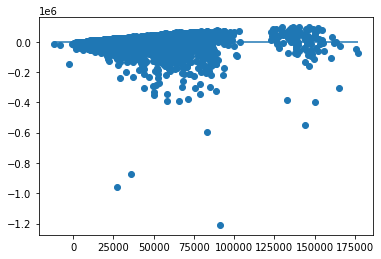

In [16]:
predictions = model.predict(X_train_scaled)
# Plot Residuals
plt.scatter(predictions, predictions - y_train)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [17]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(f"True output: {train_y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y_train[0]}")

x_min = X_train_scaled.min()
x_max = X_train_scaled.max()
y_min_actual = y_train.min()
y_max_actual = y_train.max()

y_min = 101.896225057 + (model.coef_ * x_min)
y_max = 101.896225057 + (model.coef_ * x_max)
print(f"Actual Min Value: {y_min_actual}")
print(f"Calculated Min Value: {y_min}")
print(f"Actual Max Value: {y_max_actual}")
print(f"Calculated Max Value: {y_max}")

# y_min_predicted = model.predict([[x_min]])
# y_max_predicted = model.predict([[x_max]])
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Predicted Min Value: {y_min_predicted}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Predicted Max Value: {y_max_predicted}")

# plt.scatter(X, y, c='blue')
# plt.plot([x_min, x_max], [y_min, y_max], c='red')

Weight coefficients:  [ 8460.59653569 -4375.78444026  8855.15794368  3166.55359608
  -106.39570481    43.9581025    310.35576405   987.67603501
 -3186.5745699    320.22822146 -1032.90860948 -2022.58217233
 -3407.83280829 -1548.92720996 -1190.07648423 13417.39497477
  -176.64618309 -2589.03345894 -1430.83863346 -2968.90931313
 -1126.66538229   746.6134501  -3126.78379824 -1063.7629088
 -1912.70006377 -1679.79260286   943.06917748 -1376.8883293
 -1688.57590376 -1688.09262613 -1113.67142855  -524.65338856
 -2070.89359681 -2338.37231811 10225.64529672  -823.49706467
  -748.61321945 -1033.19102516 -2077.63182479 -1136.66974611
  -772.28227898  4722.06309147 -4023.68050518  4023.68050518]
y-axis intercept:  46572.078972050294
True output: 29840.0
Predicted output: 40269.63168595027
Prediction Error: 10429.63168595027
Actual Min Value: 0.0
Calculated Min Value: [-33276.19423658  17364.90224026 -34832.78735778 -12390.54587824
    521.64032288    -71.52387783  -1122.49530859  -3794.60680572
  1

In [18]:
reg = Lasso(max_iter=10000).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.1857614771630982
Test Score: 0.10176779815815817


In [19]:
reg = Ridge(alpha=100).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.18566088517234747
Test Score: 0.10282276587026229


In [20]:
reg = ElasticNet(alpha=10).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.06038603073862969
Test Score: 0.03910520147789209


In [21]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}')
    plt.show()
    y_pred = reg.predict(X_test_scaled)
    print(mean_absolute_error(y_test, y_pred))    
    print(mean_squared_error(y_test, y_pred)) 
    print(np.median(abs(y_test - y_pred)))
    print('\n')
    return [
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        np.median(abs(y_test - y_pred)),
        y_pred,
        reg]


In [22]:
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [23]:
test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)
test_model(GradientBoostingRegressor(), data)
test_model(SGDRegressor(), data)
test_model(KernelRidge(), data)
test_model(BayesianRidge(), data)

Model: KNeighborsRegressor
Train score: 0.5712266357161743
Test Score: 0.23814604920967886
20375.924704558245
3015793430.3943048
9570.0


Model: RandomForestRegressor
Train score: 0.9140596487350294
Test Score: 0.35522463542344296
18377.381032460627
2552338681.912598
8494.5




KeyboardInterrupt: 

In [24]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(RandomForestRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)
    

Model: RandomForestRegressor
Train score: 0.4672082187636225
Test Score: 0.19902295009654913
24400.32041509095
3170661939.193985
15708.765154237462


Model: RandomForestRegressor
Train score: 0.47195652570250135
Test Score: 0.22989137770863322
24303.07900512716
3048469488.6559863
16011.556607912571


Model: RandomForestRegressor
Train score: 0.4780836117902376
Test Score: 0.24066498115058899
24243.924468506833
3005822256.272117
15937.792905437913


Model: RandomForestRegressor
Train score: 0.478207158841199
Test Score: 0.25321052222307294
24118.03085583849
2956160821.415882
15929.787305242091


Model: RandomForestRegressor
Train score: 0.4794197957916667
Test Score: 0.2596837377029113
24111.685416998345
2930536644.1081815
15990.60135522212


Model: RandomForestRegressor
Train score: 0.481331841090301
Test Score: 0.25794431595856804
24110.724193976268
2937422132.676999
16032.595241649291


Model: RandomForestRegressor
Train score: 0.4818539727069413
Test Score: 0.2573554472727445
24106.

23972.94202630915
2837363337.2877083
16076.630917917886


Model: RandomForestRegressor
Train score: 0.4827650069374868
Test Score: 0.28349912747555617
23970.09231002256
2836263593.552867
16039.302364451927


Model: RandomForestRegressor
Train score: 0.48270360306116966
Test Score: 0.2838259628078599
23977.174839266096
2834969818.2210464
16056.535074498279


Model: RandomForestRegressor
Train score: 0.4830070410535262
Test Score: 0.2832629443248005
23986.754591595116
2837198522.870592
16089.352057264608


Model: RandomForestRegressor
Train score: 0.4829335048953384
Test Score: 0.2830144913626912
23990.7118619711
2838182022.149048
16104.314028741945


Model: RandomForestRegressor
Train score: 0.4830887321938845
Test Score: 0.2830326370881924
23991.46149547554
2838110192.424073
16097.008456026939


Model: RandomForestRegressor
Train score: 0.48311856581894197
Test Score: 0.2821785815319455
23996.13983463924
2841490965.2520533
16101.245566469912


Model: RandomForestRegressor
Train score: 

Test Score: 0.3110389054425915
22704.942291307478
2727247578.893698
14417.935063731027


Model: RandomForestRegressor
Train score: 0.5564937083713143
Test Score: 0.3098730133087678
22663.953220982574
2731862754.589888
14334.936468833002


Model: RandomForestRegressor
Train score: 0.55565500649585
Test Score: 0.31025531847331755
22653.016387625798
2730349402.3227525
14380.127150494118


Model: RandomForestRegressor
Train score: 0.5567843720910202
Test Score: 0.3127624512567706
22652.58710185747
2720424935.0812025
14411.949178555165


Model: RandomForestRegressor
Train score: 0.5562979555448554
Test Score: 0.31486455270534563
22665.45739059604
2712103781.489942
14380.271177256494


Model: RandomForestRegressor
Train score: 0.55592238354446
Test Score: 0.3120062044553177
22703.89403561183
2723418532.650937
14453.019768874405


Model: RandomForestRegressor
Train score: 0.5549167271411966
Test Score: 0.3134918633725229
22698.08644745739
2717537562.42342
14458.821098886787


Model: RandomFor

Test Score: 0.3101201311110694
22684.32578654433
2730884540.5320077
14375.169908758999


Model: RandomForestRegressor
Train score: 0.5548233648474981
Test Score: 0.31048012321399454
22681.199613289522
2729459514.3601685
14358.624211940638


Model: RandomForestRegressor
Train score: 0.5547548068225238
Test Score: 0.31073298188532317
22681.997030278035
2728458575.113191
14389.329028261673


Model: RandomForestRegressor
Train score: 0.5547967730171418
Test Score: 0.3109752846017484
22676.0417697255
2727499421.5384097
14364.206002023173


Model: RandomForestRegressor
Train score: 0.5548239579281633
Test Score: 0.31041789457843516
22674.798876232515
2729705845.9701943
14395.157635154828


Model: RandomForestRegressor
Train score: 0.5548660813719364
Test Score: 0.31056725827304477
22664.408057035333
2729114590.850396
14404.186714829317


Model: RandomForestRegressor
Train score: 0.55462027236637
Test Score: 0.310418812381981
22667.606960175835
2729702212.851404
14371.319978388412


Model: Ra

Model: RandomForestRegressor
Train score: 0.6163911443000347
Test Score: 0.3294668647683915
21665.23238505585
2654300633.3371778
13145.164185535876


Model: RandomForestRegressor
Train score: 0.6162315842021306
Test Score: 0.32851646633150955
21654.414816037974
2658062778.771002
13101.225469346962


Model: RandomForestRegressor
Train score: 0.6163014574736687
Test Score: 0.3283248363424818
21661.112730094574
2658821344.7157955
13085.390159612281


Model: RandomForestRegressor
Train score: 0.6164170869477201
Test Score: 0.33104492882277636
21635.824335691315
2648053878.0332017
13089.307023458685


Model: RandomForestRegressor
Train score: 0.6164649549962964
Test Score: 0.33267709913092713
21639.604172430198
2641592943.509597
13120.941382138764


Model: RandomForestRegressor
Train score: 0.6166959424473456
Test Score: 0.3346636396569844
21644.81932302841
2633729237.005902
13131.908837772913


Model: RandomForestRegressor
Train score: 0.616253852388083
Test Score: 0.33467112574182967
2163

Model: RandomForestRegressor
Train score: 0.6174384017627541
Test Score: 0.33069729986939567
21603.11210496513
2649429964.7657475
13145.770210953357


Model: RandomForestRegressor
Train score: 0.6173099950727013
Test Score: 0.33101654033134453
21602.386648330987
2648166253.674058
13141.882470434091


Model: RandomForestRegressor
Train score: 0.6174091730954133
Test Score: 0.33079160614797476
21601.78186607533
2649056654.034618
13135.470773318732


Model: RandomForestRegressor
Train score: 0.6174394303067952
Test Score: 0.33094949295691134
21603.15733180598
2648431660.227546
13125.247927803772


Model: RandomForestRegressor
Train score: 0.617265458854637
Test Score: 0.33108277827767185
21602.824417677115
2647904051.2359533
13128.158191245817


Model: RandomForestRegressor
Train score: 0.6175094044293825
Test Score: 0.33107410857122854
21604.403754299663
2647938370.2070737
13127.43412002219


Model: RandomForestRegressor
Train score: 0.6173581611635568
Test Score: 0.3311189730238756
2160

Model: RandomForestRegressor
Train score: 0.6721398223286918
Test Score: 0.3485555626126231
20752.59962157962
2578738159.0680647
11829.553930804279


Model: RandomForestRegressor
Train score: 0.6719575278725085
Test Score: 0.3481010756190238
20756.09338670662
2580537242.590668
11845.26063577603


Model: RandomForestRegressor
Train score: 0.6721241844558867
Test Score: 0.3476395638360369
20752.23653852241
2582364133.691958
11852.086135412846


Model: RandomForestRegressor
Train score: 0.6721579181863374
Test Score: 0.34713956263570755
20747.199424600854
2584343384.877278
11830.481994162245


Model: RandomForestRegressor
Train score: 0.6728688449726716
Test Score: 0.34746212050509706
20740.776383748507
2583066541.8518953
11848.349931651861


Model: RandomForestRegressor
Train score: 0.6727652840605907
Test Score: 0.3475423949939419
20725.8940947497
2582748775.8603487
11851.798652890855


Model: RandomForestRegressor
Train score: 0.67280501096433
Test Score: 0.34788342776449277
20720.3312

20746.809788679384
2599522762.881991
11875.458188694858


Model: RandomForestRegressor
Train score: 0.6719071097373217
Test Score: 0.3432937398280915
20745.729487739514
2599567047.031471
11827.651545540713


Model: RandomForestRegressor
Train score: 0.6718610375423539
Test Score: 0.3432707200781475
20744.532572801352
2599658170.5474396
11804.80086764229


Model: RandomForestRegressor
Train score: 0.6719295598165027
Test Score: 0.3431775668878937
20746.73150079397
2600026916.7866583
11861.05564706296


Model: RandomForestRegressor
Train score: 0.6719582472824872
Test Score: 0.34356996272366813
20746.117347437463
2598473620.6694493
11865.788346117377


Model: RandomForestRegressor
Train score: 0.672136010896762
Test Score: 0.3434150464661848
20746.48034085433
2599086855.56978
11845.153217789677


Model: RandomForestRegressor
Train score: 0.6720873202547482
Test Score: 0.34370238031939315
20744.35907943084
2597949446.5612206
11853.93786006004


Model: RandomForestRegressor
Train score: 0.

20085.25843446376
2548971847.929338
11377.18240187793


Model: RandomForestRegressor
Train score: 0.7231816008823008
Test Score: 0.3553494408311094
20085.97411512605
2551844640.596506
11353.38285618708


Model: RandomForestRegressor
Train score: 0.7237619668470141
Test Score: 0.3549489932010915
20088.05095764191
2553429809.6837993
11361.611694334973


Model: RandomForestRegressor
Train score: 0.7238601272106819
Test Score: 0.35477564192797917
20100.848662134915
2554116019.4620123
11382.699128383563


Model: RandomForestRegressor
Train score: 0.7233785302613502
Test Score: 0.354959646631436
20099.9491557942
2553387638.1557646
11394.340259258373


Model: RandomForestRegressor
Train score: 0.7231816774393811
Test Score: 0.3548821087050398
20098.504452149937
2553694571.4843764
11371.370474338863


Model: RandomForestRegressor
Train score: 0.7231900800820534
Test Score: 0.3545347971145577
20099.866797684615
2555069401.938152
11359.814448081546


Model: RandomForestRegressor
Train score: 0.7

20079.26544114379
2559126177.0958605
11378.221035808256


Model: RandomForestRegressor
Train score: 0.7226695491957957
Test Score: 0.35442680851726904
20076.064789960277
2555496874.0303063
11376.627804402604


Model: RandomForestRegressor
Train score: 0.7226066951607599
Test Score: 0.3539651748594046
20078.191642558846
2557324247.57243
11372.618416651516


Model: RandomForestRegressor
Train score: 0.7225099090440487
Test Score: 0.3535165955531039
20080.00285063129
2559099945.556997
11393.459895264525


Model: RandomForestRegressor
Train score: 0.7223288005428921
Test Score: 0.35336419336647074
20076.335978065737
2559703228.5257983
11361.355217415708


Model: RandomForestRegressor
Train score: 0.7224028181831004
Test Score: 0.3531573784762907
20073.806075615357
2560521903.7934995
11386.036282758694


Model: RandomForestRegressor
Train score: 0.7224101099406159
Test Score: 0.35245321561419496
20077.436570842485
2563309327.460769
11392.128128543798


Model: RandomForestRegressor
Train sco

Test Score: 0.3612160718111752
19534.91118246046
2528621623.7047825
10721.216665982429


Model: RandomForestRegressor
Train score: 0.7689692848819834
Test Score: 0.36194635247728557
19538.801544461374
2525730812.896602
10733.97700866773


Model: RandomForestRegressor
Train score: 0.7691514438441771
Test Score: 0.3616763942043387
19538.78621907518
2526799440.7946253
10731.18482534423


Model: RandomForestRegressor
Train score: 0.7693424898634049
Test Score: 0.3618260963425197
19527.245760433678
2526206845.9483633
10719.89651327048


Model: RandomForestRegressor
Train score: 0.7688185863424642
Test Score: 0.36116202197549574
19537.016370161167
2528835579.593817
10717.085900890117


Model: RandomForestRegressor
Train score: 0.7688470683371129
Test Score: 0.361628587350489
19537.0321206289
2526988683.884614
10711.11624563887


Model: RandomForestRegressor
Train score: 0.7687235346481082
Test Score: 0.36191296412480145
19539.033898961807
2525862980.451773
10705.31380716155


Model: RandomFo

Model: RandomForestRegressor
Train score: 0.8045778610503647
Test Score: 0.36332592437642
19151.196166799567
2520269787.3734684
10220.264654350278


Model: RandomForestRegressor
Train score: 0.8050784661582523
Test Score: 0.3581448112882407
19193.803136321865
2540779186.5795126
10109.135306121927


Model: RandomForestRegressor
Train score: 0.8079073205147498
Test Score: 0.35760554693416857
19229.229750582002
2542913860.678885
10170.15423696702


Model: RandomForestRegressor
Train score: 0.8089521098353697
Test Score: 0.3545538438689563
19247.079014946998
2554994005.496713
10189.254336671715


Model: RandomForestRegressor
Train score: 0.8089262223216367
Test Score: 0.35886176654625235
19195.24448704416
2537941124.3042502
10214.117835432218


Model: RandomForestRegressor
Train score: 0.8092739115970664
Test Score: 0.3684541976115112
19165.135876872722
2499969554.3490005
10111.348278206053


Model: RandomForestRegressor
Train score: 0.8083637925341104
Test Score: 0.365217072015936
19120.2

Model: RandomForestRegressor
Train score: 0.8062111831629039
Test Score: 0.3663372617039562
19132.434672231895
2508349430.0403285
10191.496688753166


Model: RandomForestRegressor
Train score: 0.8063351825754443
Test Score: 0.3657257943332094
19136.433640432864
2510769919.2662306
10212.455640701653


Model: RandomForestRegressor
Train score: 0.8063669624766344
Test Score: 0.36532412689765426
19127.919754904793
2512359916.9450426
10198.863892721096


Model: RandomForestRegressor
Train score: 0.8063957435001357
Test Score: 0.36557808163411454
19120.918872433773
2511354638.932059
10201.15270782142


Model: RandomForestRegressor
Train score: 0.8064362096478881
Test Score: 0.3642795257550664
19128.95428727686
2516494963.1175156
10180.562175492123


Model: RandomForestRegressor
Train score: 0.8064069533357434
Test Score: 0.36530088962508456
19122.89836567311
2512451901.5227737
10228.08553968693


Model: RandomForestRegressor
Train score: 0.8065408110257839
Test Score: 0.36602640107202744
191

Model: RandomForestRegressor
Train score: 0.8371636004889457
Test Score: 0.3693387833347196
18901.81422130442
2496467928.0728555
9696.227836069054


Model: RandomForestRegressor
Train score: 0.8361972380553222
Test Score: 0.37068363912635716
18895.893954848896
2491144326.0136404
9644.422872604653


Model: RandomForestRegressor
Train score: 0.8365554572660153
Test Score: 0.3700884028173278
18903.383496132417
2493500564.6974993
9727.360795802233


Model: RandomForestRegressor
Train score: 0.8369421804065326
Test Score: 0.3676133450338531
18903.477936834402
2503298063.2804046
9726.821240507921


Model: RandomForestRegressor
Train score: 0.8366136985813876
Test Score: 0.3657796766790721
18931.966617092785
2510556626.384441
9776.245743333871


Model: RandomForestRegressor
Train score: 0.8357406763314776
Test Score: 0.3649621573134374
18939.32340868114
2513792770.9624715
9734.004939520475


Model: RandomForestRegressor
Train score: 0.834868090531037
Test Score: 0.3658406113351611
18925.17202

Model: RandomForestRegressor
Train score: 0.8357672829126472
Test Score: 0.36814828692124757
18825.832831440835
2501180499.6345468
9803.04491747414


Model: RandomForestRegressor
Train score: 0.8355810748016711
Test Score: 0.3677970604634718
18824.512784645372
2502570827.062582
9772.70923900578


Model: RandomForestRegressor
Train score: 0.8359296334125988
Test Score: 0.3673243259237955
18828.712114816408
2504442143.3661823
9772.786400004858


Model: RandomForestRegressor
Train score: 0.8358083384832417
Test Score: 0.36731562722138944
18827.676190443453
2504476577.1176143
9789.521151595956


Model: RandomForestRegressor
Train score: 0.8355440240319955
Test Score: 0.3677927562976523
18829.947697565876
2502587865.07228
9787.908466146378


Model: RandomForestRegressor
Train score: 0.8355072621768271
Test Score: 0.3684134506560881
18825.278444062955
2500130850.881421
9808.52834661079


Model: RandomForestRegressor
Train score: 0.8355796024711946
Test Score: 0.3680179995566577
18835.6714543

Model: RandomForestRegressor
Train score: 0.8567557108496207
Test Score: 0.38003088998140655
18658.096287058946
2454143300.1717935
9387.104115310143


Model: RandomForestRegressor
Train score: 0.856438269051061
Test Score: 0.3803856772908807
18648.374326606812
2452738877.137708
9354.504353635362


Model: RandomForestRegressor
Train score: 0.8565159242557971
Test Score: 0.38091257823087243
18648.94836064195
2450653143.524792
9344.162079762104


Model: RandomForestRegressor
Train score: 0.8561965152851243
Test Score: 0.378911932560253
18653.17090038272
2458572685.142634
9393.734678515255


Model: RandomForestRegressor
Train score: 0.8561113881065208
Test Score: 0.3809929265038905
18641.022993201834
2450335085.4591227
9391.363532919393


Model: RandomForestRegressor
Train score: 0.8562239318614939
Test Score: 0.38133526807339624
18635.18503769235
2448979928.797934
9377.193332815019


Model: RandomForestRegressor
Train score: 0.8565272587576501
Test Score: 0.3808185323420833
18631.62493529

Model: RandomForestRegressor
Train score: 0.8562876977477063
Test Score: 0.3750447617451963
18604.23621734176
2473880853.2320194
9420.517990307439


Model: RandomForestRegressor
Train score: 0.8561578940077563
Test Score: 0.3749997559732876
18600.970665024903
2474059008.259123
9404.784981622623


Model: RandomForestRegressor
Train score: 0.8561838295578519
Test Score: 0.3753242496921485
18605.029692755652
2472774502.1874146
9422.537178149181


Model: RandomForestRegressor
Train score: 0.8561595802917419
Test Score: 0.37573660355291616
18603.53926700884
2471142202.3706183
9417.8240588478


Model: RandomForestRegressor
Train score: 0.8561239784849557
Test Score: 0.37615520817873827
18601.105082800463
2469485158.9449363
9417.939903582934


Model: RandomForestRegressor
Train score: 0.8561141320715638
Test Score: 0.3758098065977229
18603.674942603928
2470852428.6398606
9383.664697932712


Model: RandomForestRegressor
Train score: 0.8561871736503684
Test Score: 0.3757441178380405
18602.68733

Model: RandomForestRegressor
Train score: 0.872747287174952
Test Score: 0.3815284837796816
18420.420299463643
2448215085.8026853
9134.91894775374


Model: RandomForestRegressor
Train score: 0.8731152174039891
Test Score: 0.38042119609496383
18418.99613633102
2452598276.205077
9064.774015058229


Model: RandomForestRegressor
Train score: 0.872866019322704
Test Score: 0.3796442771007753
18422.122040569157
2455673704.502314
9130.05475711032


Model: RandomForestRegressor
Train score: 0.8725427273802792
Test Score: 0.37905938554207386
18421.02995906441
2457988993.5657825
9071.600120350347


Model: RandomForestRegressor
Train score: 0.8722624353107976
Test Score: 0.37792452316509106
18427.722736761287
2462481338.190833
9029.332501360754


Model: RandomForestRegressor
Train score: 0.8728079766631337
Test Score: 0.3764210985994857
18438.7538612836
2468432633.6108313
9074.084979112555


Model: RandomForestRegressor
Train score: 0.8730137572098011
Test Score: 0.3767609707445242
18443.4362148225

Model: RandomForestRegressor
Train score: 0.8720299452094381
Test Score: 0.3744624845575314
18442.350608511948
2476185793.326386
9068.407186873592


Model: RandomForestRegressor
Train score: 0.8720961526605611
Test Score: 0.37452493068866055
18446.121898184134
2475938600.761699
9058.360130897385


Model: RandomForestRegressor
Train score: 0.872037646945923
Test Score: 0.37472892591897566
18442.756227689853
2475131087.097462
9044.149537061


Model: RandomForestRegressor
Train score: 0.8722476189418051
Test Score: 0.374972892406632
18443.113350000018
2474165347.4961286
9037.735273668532


Model: RandomForestRegressor
Train score: 0.8722790338436012
Test Score: 0.3760508327227131
18438.71392326689
2469898328.4431696
9043.66467537691


Model: RandomForestRegressor
Train score: 0.8723639075315127
Test Score: 0.3756450831129142
18441.19628662764
2471504485.37961
9022.688554246666


Model: RandomForestRegressor
Train score: 0.8722432739915584
Test Score: 0.37525707543292075
18442.50303438782


Model: RandomForestRegressor
Train score: 0.8837668961786306
Test Score: 0.38072939716378995
18260.055013116234
2451378264.472327
8883.288873029145


Model: RandomForestRegressor
Train score: 0.8834413539182467
Test Score: 0.38100724444564005
18255.102544561574
2450278407.9888277
8887.972575528358


Model: RandomForestRegressor
Train score: 0.8834902476792323
Test Score: 0.3808120632708589
18259.332496042454
2451051031.277098
8838.732882328386


Model: RandomForestRegressor
Train score: 0.8834809334785005
Test Score: 0.3810792097343858
18259.316188021618
2449993533.906609
8861.56861923954


Model: RandomForestRegressor
Train score: 0.8833693007333356
Test Score: 0.3818885787719657
18251.22390562643
2446789652.344052
8856.375079876962


Model: RandomForestRegressor
Train score: 0.8834816542146446
Test Score: 0.3813371147728397
18251.462504283554
2448972618.6513586
8831.636359347693


Model: RandomForestRegressor
Train score: 0.8836795383010932
Test Score: 0.38180691815762646
18239.82510

Model: RandomForestRegressor
Train score: 0.867782702924434
Test Score: 0.3573721866455509
18801.228355004638
2543837615.716971
8905.504269523684


Model: RandomForestRegressor
Train score: 0.8805178196564022
Test Score: 0.3799238501738438
18466.65503777644
2454567016.486586
8899.25993352702


Model: RandomForestRegressor
Train score: 0.8855849789307613
Test Score: 0.3802978595176082
18464.061497460014
2453086503.1668596
8811.45625


Model: RandomForestRegressor
Train score: 0.8894305142063575
Test Score: 0.3841269971575584
18262.81331452317
2437928889.1298676
8581.951114545736


Model: RandomForestRegressor
Train score: 0.889933076250247
Test Score: 0.37909457978815164
18292.24579828593
2457849677.3937016
8714.28571428571


Model: RandomForestRegressor
Train score: 0.891064447282137
Test Score: 0.37890510652751874
18290.81936300839
2458599705.9445267
8625.574900280291


Model: RandomForestRegressor
Train score: 0.8918521428712423
Test Score: 0.37584035567803886
18286.305289114323
2470

Model: RandomForestRegressor
Train score: 0.8919271821080393
Test Score: 0.38125246914692934
18193.2536203872
2449307687.7578025
8600.6558157146


Model: RandomForestRegressor
Train score: 0.8921500339978902
Test Score: 0.3797889517855426
18197.297137159574
2455101010.7945333
8569.555825759591


Model: RandomForestRegressor
Train score: 0.8917854780393618
Test Score: 0.38026210702765206
18197.60479639507
2453228029.143352
8589.098946542552


Model: RandomForestRegressor
Train score: 0.8918144800106492
Test Score: 0.3799516865256214
18202.427085181367
2454456826.4866123
8581.678401724384


Model: RandomForestRegressor
Train score: 0.891829674209785
Test Score: 0.3787279799291121
18208.18248267161
2459300860.3209906
8571.478793981136


Model: RandomForestRegressor
Train score: 0.8917372469304012
Test Score: 0.37843610007398043
18197.38440275944
2460456264.64574
8593.447581066994


Model: RandomForestRegressor
Train score: 0.8919325090947112
Test Score: 0.37854036832384563
18195.318904195

Model: RandomForestRegressor
Train score: 0.8980307132015852
Test Score: 0.38081401477536714
18137.004215540586
2451043306.2604213
8462.147427039345


Model: RandomForestRegressor
Train score: 0.8990208036335183
Test Score: 0.3814054050179123
18161.1376054798
2448702292.203308
8421.011148687121


Model: RandomForestRegressor
Train score: 0.8985102107692693
Test Score: 0.38239107591646726
18169.426935726966
2444800520.9815288
8393.706162012459


Model: RandomForestRegressor
Train score: 0.8992117106990182
Test Score: 0.376909852978761
18208.03428801962
2466497902.886437
8465.838326763933


Model: RandomForestRegressor
Train score: 0.8988213201969169
Test Score: 0.3790278694395641
18203.987616153543
2458113749.832783
8418.385170788162


Model: RandomForestRegressor
Train score: 0.8993106426788187
Test Score: 0.3785194602003933
18214.627236477223
2460126284.1798882
8487.16674550375


Model: RandomForestRegressor
Train score: 0.899653358588181
Test Score: 0.3765021955033563
18193.790715401

Model: RandomForestRegressor
Train score: 0.8987714328022967
Test Score: 0.38048457790778234
18123.06469229257
2452347379.7510967
8387.629683724237


Model: RandomForestRegressor
Train score: 0.8988615182502856
Test Score: 0.38048520414410114
18120.372086394087
2452344900.799095
8382.768370382139


Model: RandomForestRegressor
Train score: 0.8988705289499475
Test Score: 0.3795150918328358
18125.470930201052
2456185083.4640584
8383.307426936586


Model: RandomForestRegressor
Train score: 0.898789339981089
Test Score: 0.3796400921435342
18119.609651508417
2455690270.6257043
8395.56782106783


Model: RandomForestRegressor
Train score: 0.8985321824682266
Test Score: 0.3793658618233515
18118.977737710553
2456775809.392241
8397.391384006114


Model: RandomForestRegressor
Train score: 0.8989315367917392
Test Score: 0.3789581884934279
18119.52333745729
2458389581.361075
8387.545661788645


Model: RandomForestRegressor
Train score: 0.8987479178027842
Test Score: 0.3790171001534631
18115.5852327

Model: RandomForestRegressor
Train score: 0.9008795347152594
Test Score: 0.37691602704940586
18127.775690625247
2466473462.871825
8414.812638059502


Model: RandomForestRegressor
Train score: 0.9010924431761723
Test Score: 0.38023094005130975
18113.216047350208
2453351403.396909
8453.425974235104


Model: RandomForestRegressor
Train score: 0.9015901256680213
Test Score: 0.38222449211357357
18105.10193046881
2445459941.777149
8429.648075546604


Model: RandomForestRegressor
Train score: 0.9017806653419198
Test Score: 0.38401822197147106
18104.223089967738
2438359474.9281716
8394.79791811572


Model: RandomForestRegressor
Train score: 0.9017182063164346
Test Score: 0.38454348502324687
18092.775314068367
2436280224.884077
8415.025113093845


Model: RandomForestRegressor
Train score: 0.9018897423684492
Test Score: 0.38526619158105346
18086.40158501071
2433419396.1295958
8377.044176907726


Model: RandomForestRegressor
Train score: 0.901898474759301
Test Score: 0.3866684169954545
18073.2159

Model: RandomForestRegressor
Train score: 0.9028343733746729
Test Score: 0.38097115906645507
18079.263812117515
2450421251.7049575
8409.870730470893


Model: RandomForestRegressor
Train score: 0.9028461737305845
Test Score: 0.381083578185312
18083.85881759179
2449976241.424775
8398.237976119999


Model: RandomForestRegressor
Train score: 0.9026887636960411
Test Score: 0.3810948909087446
18084.31502560058
2449931460.0897536
8389.600096443639


Model: RandomForestRegressor
Train score: 0.9029705824666275
Test Score: 0.38104370017720746
18084.70049131691
2450134098.235433
8405.2815054003


Model: RandomForestRegressor
Train score: 0.9027507421310306
Test Score: 0.3809828731605218
18089.05906489063
2450374881.5471435
8408.073486471654


Model: RandomForestRegressor
Train score: 0.9025733771079065
Test Score: 0.38073412385792627
18088.41472236553
2451359553.887301
8384.45327493611


Model: RandomForestRegressor
Train score: 0.9026313359476608
Test Score: 0.38087992818037586
18094.6380836571

8367.459020767059


Model: RandomForestRegressor
Train score: 0.905706035592337
Test Score: 0.3845656436919619
18105.01049291991
2436192509.952012
8437.215448348434


Model: RandomForestRegressor
Train score: 0.9062764077608735
Test Score: 0.3852934035116692
18102.6759212589
2433311677.8963385
8409.881582540133


Model: RandomForestRegressor
Train score: 0.906138360099223
Test Score: 0.3855379546549692
18088.755203822893
2432343623.93981
8362.133749330613


Model: RandomForestRegressor
Train score: 0.9062837606766664
Test Score: 0.3854817847159866
18092.859964868945
2432565972.242649
8432.77488425926


Model: RandomForestRegressor
Train score: 0.9065723774926486
Test Score: 0.3848407484080487
18088.915502935233
2435103509.8955255
8422.297184684683


Model: RandomForestRegressor
Train score: 0.9063850011404417
Test Score: 0.3843639047568628
18089.786657248616
2436991092.087729
8410.67923082272


Model: RandomForestRegressor
Train score: 0.9061223358526207
Test Score: 0.3834722147925381


Model: RandomForestRegressor
Train score: 0.9055649170120377
Test Score: 0.38169286269745306
18081.344904220266
2447564393.029095
8348.603895524098


Model: RandomForestRegressor
Train score: 0.9058122210820226
Test Score: 0.38161135994628537
18081.54676581499
2447887021.0882864
8353.231904942088


Model: RandomForestRegressor
Train score: 0.905809287260733
Test Score: 0.3818872496774175
18080.440975611567
2446794913.555342
8338.627174902227


Model: RandomForestRegressor
Train score: 0.90578117926515
Test Score: 0.381626071899999
18085.33633924298
2447828783.924442
8339.934065934067


Model: RandomForestRegressor
Train score: 0.9058633332331911
Test Score: 0.3817173993776012
18091.932256159616
2447467264.755733
8393.678758056529


Model: RandomForestRegressor
Train score: 0.9057844214788824
Test Score: 0.3818956193724494
18089.217814856216
2446761782.1772537
8394.078130294387


Model: RandomForestRegressor
Train score: 0.9060072367087789
Test Score: 0.3820005900496637
18087.5439825577

Model: RandomForestRegressor
Train score: 0.9086573387949558
Test Score: 0.38348858312063816
18081.337255793314
2440456046.541624
8479.360187156006


Model: RandomForestRegressor
Train score: 0.9086562155989578
Test Score: 0.38352441491799616
18079.955050216933
2440314206.627347
8493.633503522971


Model: RandomForestRegressor
Train score: 0.9087170304232255
Test Score: 0.38322210142870095
18084.42257414624
2441510912.4185166
8469.164672710576


Model: RandomForestRegressor
Train score: 0.9086919453869721
Test Score: 0.3839339713558675
18080.586556659597
2438692980.3891335
8465.12413467513


Model: RandomForestRegressor
Train score: 0.9083154504127685
Test Score: 0.38417489270670246
18076.005819250266
2437739294.940189
8439.908034939726


Model: RandomForestRegressor
Train score: 0.9083474338924029
Test Score: 0.3839408822764998
18078.722408494406
2438665623.5591016
8432.318909051894


Model: RandomForestRegressor
Train score: 0.9083196377939358
Test Score: 0.3842588195552501
18079.228

Model: RandomForestRegressor
Train score: 0.908452510168506
Test Score: 0.3827268427204146
18082.540473448164
2443471390.4829097
8429.338775510201


Model: RandomForestRegressor
Train score: 0.9085688542015042
Test Score: 0.3824918949663242
18085.185859482168
2444401429.491747
8298.946030030907


Model: RandomForestRegressor
Train score: 0.9086098715916463
Test Score: 0.381784431963901
18090.184418866455
2447201916.740965
8423.569174765704


Model: RandomForestRegressor
Train score: 0.8699707138318793
Test Score: 0.2894219942058417
19747.936111298157
2812817967.8449907
8702.208771929825


Model: RandomForestRegressor
Train score: 0.88924774026429
Test Score: 0.3605861714048384
18757.3104877439
2531115079.9705963
8545.799814073223


Model: RandomForestRegressor
Train score: 0.8994518297509837
Test Score: 0.37176781587458674
18485.394009145388
2486852620.088502
8519.102429935017


Model: RandomForestRegressor
Train score: 0.903933013197747
Test Score: 0.3803657098389108
18346.29994861536

Model: RandomForestRegressor
Train score: 0.9103039184521817
Test Score: 0.38539992300741066
18072.61914670011
2432890021.23218
8382.783567752995


Model: RandomForestRegressor
Train score: 0.9103677602763818
Test Score: 0.3858841721949168
18082.667823235446
2430973124.277272
8419.445750861632


Model: RandomForestRegressor
Train score: 0.9102225743911676
Test Score: 0.3856738241388099
18090.400630219236
2431805785.557095
8450.116933291654


Model: RandomForestRegressor
Train score: 0.9101578064795715
Test Score: 0.385535020522339
18092.307889613956
2432355238.6828995
8443.235119047618


Model: RandomForestRegressor
Train score: 0.9103601332754022
Test Score: 0.3853072771852315
18096.579988465943
2433256759.058494
8458.884880044468


Model: RandomForestRegressor
Train score: 0.9105267246251988
Test Score: 0.3839226005333568
18103.779281918658
2438737991.7089415
8450.470443349755


Model: RandomForestRegressor
Train score: 0.9102521178497518
Test Score: 0.3841671286041981
18099.44898464

Model: RandomForestRegressor
Train score: 0.9095522790703595
Test Score: 0.3670483609419515
18320.460146499925
2505534548.778533
8466.90037230894


Model: RandomForestRegressor
Train score: 0.9094804438046129
Test Score: 0.36843265980419415
18266.036937274497
2500054811.6056495
8285.14896349486


Model: RandomForestRegressor
Train score: 0.9107113785803227
Test Score: 0.37828892549715776
18206.74519660366
2461038854.158392
8435.245927941825


Model: RandomForestRegressor
Train score: 0.9104027367623466
Test Score: 0.3779311755840564
18158.1632620268
2462455004.637806
8326.35


Model: RandomForestRegressor
Train score: 0.9099143893600397
Test Score: 0.37848236575255023
18129.688265007833
2460273122.2871046
8383.43051540399


Model: RandomForestRegressor
Train score: 0.9108421757406893
Test Score: 0.38003642564651996
18135.939699580347
2454121387.280925
8383.83783492617


Model: RandomForestRegressor
Train score: 0.9104764337080686
Test Score: 0.38049503307209487
18137.48545777763
245230

Model: RandomForestRegressor
Train score: 0.9114948259457512
Test Score: 0.37954590026657764
18096.244776262585
2456063128.498828
8340.942559339732


Model: RandomForestRegressor
Train score: 0.9115712710409812
Test Score: 0.3782344358223294
18108.661757531692
2461254551.1475606
8363.823789881131


Model: RandomForestRegressor
Train score: 0.9114647896071905
Test Score: 0.3786421318130717
18101.303395749594
2459640689.4760375
8331.813076923077


Model: RandomForestRegressor
Train score: 0.9115868628436152
Test Score: 0.37919445791913964
18094.343739741194
2457454310.5245514
8312.859705334653


Model: RandomForestRegressor
Train score: 0.9117277093592816
Test Score: 0.3800968824501939
18087.86201507024
2453882069.4547806
8326.872675701554


Model: RandomForestRegressor
Train score: 0.9117928108712631
Test Score: 0.3803501181002005
18082.084960202894
2452879637.940395
8334.461029411765


Model: RandomForestRegressor
Train score: 0.9118634099386723
Test Score: 0.3795449745427012
18086.378

Model: RandomForestRegressor
Train score: 0.9122792816165386
Test Score: 0.3742800375829747
18218.34255965562
2476908008.3738933
8419.67717200752


Model: RandomForestRegressor
Train score: 0.9119511711596648
Test Score: 0.3740635288292842
18235.61710760085
2477765056.7311606
8466.578947368427


Model: RandomForestRegressor
Train score: 0.9113798570047454
Test Score: 0.37433512254364576
18235.154131496824
2476689954.9499617
8472.78487831097


Model: RandomForestRegressor
Train score: 0.9105942524878897
Test Score: 0.3752116438734361
18226.71232753847
2473220251.517644
8528.046464244464


Model: RandomForestRegressor
Train score: 0.910410881589004
Test Score: 0.3760055918788916
18223.73354763592
2470077414.0007634
8531.890909090915


Model: RandomForestRegressor
Train score: 0.9108057279804243
Test Score: 0.37952107064820406
18212.252910467523
2456161416.366066
8611.134782608695


Model: RandomForestRegressor
Train score: 0.911228158883263
Test Score: 0.3818604589711774
18208.6613946678

Train score: 0.9129860637957199
Test Score: 0.37850562875955684
18121.717057770064
2460181035.8397884
8456.089425696926


Model: RandomForestRegressor
Train score: 0.9127078592458387
Test Score: 0.3790511435916585
18120.34789269577
2458021619.2677174
8415.352242803103


Model: RandomForestRegressor
Train score: 0.9126278086364145
Test Score: 0.37936255744705083
18121.43122389888
2456788889.742259
8406.337746566362


Model: RandomForestRegressor
Train score: 0.9126701912498998
Test Score: 0.3794672784205906
18125.601766591713
2456374352.5154085
8418.978670383869


Model: RandomForestRegressor
Train score: 0.9125763209393019
Test Score: 0.37931279387054206
18127.18024914434
2456985878.5049376
8422.892207792207


Model: RandomForestRegressor
Train score: 0.9125690113092905
Test Score: 0.37951378808786895
18127.389330929513
2456190244.3292108
8429.999774423872


Model: RandomForestRegressor
Train score: 0.9123963942148874
Test Score: 0.3793337049678951
18128.085933706774
2456903102.075211


Model: RandomForestRegressor
Train score: 0.9125332567164285
Test Score: 0.3860536362191813
18176.480003170404
2430302302.145898
8485.408688871317


Model: RandomForestRegressor
Train score: 0.9124699781023952
Test Score: 0.38841431256852677
18168.020573036447
2420957581.6541843
8495.821413043486


Model: RandomForestRegressor
Train score: 0.9125072203234195
Test Score: 0.38760926543587326
18165.770589913067
2424144354.986915
8411.65806451613


Model: RandomForestRegressor
Train score: 0.9128031823823678
Test Score: 0.38686699967239424
18171.041484405923
2427082608.7175474
8476.726868833794


Model: RandomForestRegressor
Train score: 0.9128188803739924
Test Score: 0.385955211992252
18169.254205594967
2430691913.746201
8535.051515151514


Model: RandomForestRegressor
Train score: 0.9135348921393391
Test Score: 0.3861377879820983
18173.447983950453
2429969187.9925904
8450.322945947199


Model: RandomForestRegressor
Train score: 0.9133712920985809
Test Score: 0.3857535451335563
18156.1006

Train score: 0.9127060932049007
Test Score: 0.3811867469007981
18151.915211178297
2449567848.800359
8445.278039716728


Model: RandomForestRegressor
Train score: 0.9126477692446453
Test Score: 0.38162059880824906
18149.394034650555
2447850449.119098
8444.532941176469


Model: RandomForestRegressor
Train score: 0.91261228467251
Test Score: 0.3814745350137341
18152.34759659639
2448428641.6079073
8422.64534883721


Model: RandomForestRegressor
Train score: 0.9127055320637699
Test Score: 0.38129729550111147
18153.569991748227
2449130242.954489
8448.485346277066


Model: RandomForestRegressor
Train score: 0.9126096736090734
Test Score: 0.3812953128549127
18154.506970091476
2449138091.2453265
8425.321469501561


Model: RandomForestRegressor
Train score: 0.912879489343932
Test Score: 0.3810764044432613
18155.544978824597
2450004638.6315174
8427.0


Model: RandomForestRegressor
Train score: 0.9129086838400298
Test Score: 0.38127920178724306
18156.06674938008
2449201866.791787
8409.867777777778

18143.834590352842
2432968256.603151
8547.104174123408


Model: RandomForestRegressor
Train score: 0.9133076427124129
Test Score: 0.3840970655554625
18150.67006281767
2438047373.1632814
8561.311304855124


Model: RandomForestRegressor
Train score: 0.913804799151918
Test Score: 0.3830506825799277
18155.660249850418
2442189472.708766
8611.502439024393


Model: RandomForestRegressor
Train score: 0.9139701916505203
Test Score: 0.38304090373806043
18156.312595397838
2442228182.1845517
8613.077380952382


Model: RandomForestRegressor
Train score: 0.9137328837972079
Test Score: 0.3826143707880927
18154.860668449826
2443916609.8248167
8573.525581395348


Model: RandomForestRegressor
Train score: 0.9137573150597594
Test Score: 0.3822231244529576
18158.93701678352
2445465355.651943
8527.49166893449


Model: RandomForestRegressor
Train score: 0.913846947885374
Test Score: 0.3822404254363644
18159.992662227953
2445396869.832524
8470.530454134423


Model: RandomForestRegressor
Train score: 0.913913

18174.341840238387
2448793867.4517803
8466.987305777373


Model: RandomForestRegressor
Train score: 0.9136843424138195
Test Score: 0.38267614374305814
18170.581593958697
2443672082.023172
8489.181295982786


Model: RandomForestRegressor
Train score: 0.9137743577483111
Test Score: 0.38216236369013334
18174.289466762275
2445705876.698216
8499.485416666666


Model: RandomForestRegressor
Train score: 0.9136883274410984
Test Score: 0.3818266131972132
18175.603251054083
2447034942.62975
8514.591752577318


Model: RandomForestRegressor
Train score: 0.913551980859357
Test Score: 0.38163878852910593
18173.51757104342
2447778445.2388215
8521.877551020414


Model: RandomForestRegressor
Train score: 0.9136868119406016
Test Score: 0.38144338501045594
18173.49873515582
2448551948.6737113
8521.68080186255


Model: RandomForestRegressor
Train score: 0.9137138078124751
Test Score: 0.38071308956176697
18179.755651282558
2451442817.9986234
8534.787100143003


Model: RandomForestRegressor
Train score: 0.8

Model: RandomForestRegressor
Train score: 0.9137568705999628
Test Score: 0.38233181637885993
18172.90971437981
2445035099.438487
8443.304629609662


Model: RandomForestRegressor
Train score: 0.9139966127331144
Test Score: 0.38209021964511425
18175.793468349504
2445991458.3858676
8469.83824024559


Model: RandomForestRegressor
Train score: 0.914254674546853
Test Score: 0.3820097498463285
18165.331397875205
2446309997.5104218
8475.058379294038


Model: RandomForestRegressor
Train score: 0.9137058382779965
Test Score: 0.3818147034323929
18175.515193416602
2447082087.348847
8433.16037735849


Model: RandomForestRegressor
Train score: 0.9138006290543206
Test Score: 0.38222820778593725
18183.047448671332
2445445233.3145995
8413.535376116426


Model: RandomForestRegressor
Train score: 0.913670551520354
Test Score: 0.3817394821567356
18193.55561770497
2447379850.2320313
8497.533007544425


Model: RandomForestRegressor
Train score: 0.9135642317618858
Test Score: 0.3818427821593816
18192.7682354

Model: RandomForestRegressor
Train score: 0.9094986586663014
Test Score: 0.37998576567118414
18319.39727982585
2454321924.4319673
8575.262639869274


Model: RandomForestRegressor
Train score: 0.9115628739321893
Test Score: 0.3784044176140837
18337.56531651484
2460581679.4372706
8526.138095238093


Model: RandomForestRegressor
Train score: 0.9120714532359917
Test Score: 0.37415829484239715
18311.94338953331
2477389926.1441574
8482.10833333333


Model: RandomForestRegressor
Train score: 0.9120706155813812
Test Score: 0.37589188139370266
18254.66970111543
2470527536.145361
8563.444444444445


Model: RandomForestRegressor
Train score: 0.9132327822323512
Test Score: 0.3865688762069118
18217.892825884177
2428262728.3293386
8609.11


Model: RandomForestRegressor
Train score: 0.913161837582458
Test Score: 0.3843835386536816
18185.927356105192
2436913371.447208
8460.81019508269


Model: RandomForestRegressor
Train score: 0.9126209690891002
Test Score: 0.3850596095688428
18172.032370117984
24342

Test Score: 0.378498057203168
18192.785786221735
2460211007.791751
8606.532786885247


Model: RandomForestRegressor
Train score: 0.9139602777212003
Test Score: 0.37865113636289116
18181.398897532337
2459605045.029801
8557.568670307242


Model: RandomForestRegressor
Train score: 0.9142014107807598
Test Score: 0.37858035998338
18181.625225934276
2459885212.823294
8549.75507936508


Model: RandomForestRegressor
Train score: 0.9142972900298217
Test Score: 0.3771381170327738
18192.95259510135
2465594321.256687
8556.733738659677


Model: RandomForestRegressor
Train score: 0.9141865318236025
Test Score: 0.37813643697593624
18184.919658454077
2461642478.8820457
8568.563379120875


Model: RandomForestRegressor
Train score: 0.9143252682145011
Test Score: 0.37866963171201107
18179.60635118673
2459531831.322225
8554.84160516494


Model: RandomForestRegressor
Train score: 0.9144766325516815
Test Score: 0.3795923471646906
18172.86798047807
2455879268.783923
8556.81961162882


Model: RandomForestRegr

Model: RandomForestRegressor
Train score: 0.9146106481995615
Test Score: 0.3729436970956914
18291.114914911224
2482197902.6615553
8510.899159663866


Model: RandomForestRegressor
Train score: 0.914908824898117
Test Score: 0.3708106062301759
18283.359464887562
2490641727.6387477
8451.74444444444


Model: RandomForestRegressor
Train score: 0.9146098697594452
Test Score: 0.36918571409892864
18297.338641152863
2497073851.55099
8502.754512611304


Model: RandomForestRegressor
Train score: 0.9138740855261247
Test Score: 0.3692247666993791
18302.090085817257
2496919262.110644
8520.381443779137


Model: RandomForestRegressor
Train score: 0.913089038341513
Test Score: 0.37084629961144877
18285.741290540347
2490500435.643557
8609.204761904763


Model: RandomForestRegressor
Train score: 0.9127716067555995
Test Score: 0.37165645304790573
18281.3479023715
2487293449.0436397
8572.909090909092


Model: RandomForestRegressor
Train score: 0.9131086308987978
Test Score: 0.3751466298336875
18269.53575008

Model: RandomForestRegressor
Train score: 0.9148763503199523
Test Score: 0.3767100455171464
18191.500396841737
2467288839.2981424
8449.468926982747


Model: RandomForestRegressor
Train score: 0.9147120022550556
Test Score: 0.3766655170796538
18190.343245505013
2467465104.800364
8477.532876712328


Model: RandomForestRegressor
Train score: 0.9144448723278262
Test Score: 0.37755206989775947
18184.77194225189
2463955691.793098
8408.763064842358


Model: RandomForestRegressor
Train score: 0.914383513296444
Test Score: 0.3781048538108367
18180.49884139332
2461767500.61583
8430.918131231265


Model: RandomForestRegressor
Train score: 0.9143852177192734
Test Score: 0.37822328302649055
18181.847140663598
2461298699.410343
8408.079875374788


Model: RandomForestRegressor
Train score: 0.9142930208397184
Test Score: 0.37834907974447973
18181.488378389076
2460800733.999409
8433.514285714293


Model: RandomForestRegressor
Train score: 0.9142933856506129
Test Score: 0.37843136527046906
18182.5628263

Model: RandomForestRegressor
Train score: 0.9138494875035795
Test Score: 0.3862873925463042
18224.0808236486
2429376979.392214
8503.378571428571


Model: RandomForestRegressor
Train score: 0.9135885299809471
Test Score: 0.38522097584886716
18221.26905562624
2433598382.282961
8516.103448275862


Model: RandomForestRegressor
Train score: 0.9135211072102607
Test Score: 0.387116604856912
18212.227218090607
2426094548.3749056
8577.978974358974


Model: RandomForestRegressor
Train score: 0.9135501715690191
Test Score: 0.38714612132823556
18211.49690294829
2425977707.6336927
8542.770967741933


Model: RandomForestRegressor
Train score: 0.913838270260761
Test Score: 0.3870240953207945
18206.767561476587
2426460746.713816
8537.253404605264


Model: RandomForestRegressor
Train score: 0.9138439634455019
Test Score: 0.3864752343012253
18202.51476780511
2428633409.145112
8589.469696969696


Model: RandomForestRegressor
Train score: 0.9144941121649625
Test Score: 0.38666833964588376
18207.9672445563

Train score: 0.9143236978151683
Test Score: 0.3794118058381799
18195.21182856225
2456593940.3372316
8496.377108433735


Model: RandomForestRegressor
Train score: 0.9142381709037327
Test Score: 0.3796383042253223
18193.930010850552
2455697348.0871944
8491.204365079364


Model: RandomForestRegressor
Train score: 0.9141697441458723
Test Score: 0.37999841845742177
18194.57242732103
2454271838.4678893
8506.896880148925


Model: RandomForestRegressor
Train score: 0.9141473123563575
Test Score: 0.37989743617202276
18197.9267578893
2454671576.1244006
8501.868604651158


Model: RandomForestRegressor
Train score: 0.9141906592143495
Test Score: 0.379681542377726
18199.265558792828
2455526190.169294
8490.796606277941


Model: RandomForestRegressor
Train score: 0.9140716260009134
Test Score: 0.3799006100653962
18201.039855504445
2454659012.2901187
8485.097727272725


Model: RandomForestRegressor
Train score: 0.9143098138299806
Test Score: 0.37983364240884343
18198.056450556927
2454924103.2809463
84

In [25]:
print(min(mae_list))
print(min(mse_list))
print(min(median_list))

18052.54442683283
2399804349.1442146
8207.662100779871


In [26]:
print(mae_list.index(18052.54442683283))
print(mse_list.index(2399804349.1442146))
print(median_list.index(8207.662100779871))

1311
1609
1403


In [27]:
print(mae_list[1609])
print(mse_list[1609])
print(median_list[1609])

18097.352530729473
2399804349.1442146
8430.449171472803


In [29]:
mse_list = []
mae_list = []
median_list = []
for i in range(15,35):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(ExtraTreesRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

Model: ExtraTreesRegressor
Train score: 0.904209472227466
Test Score: 0.2997916908235443
19046.167397403522
2771769597.744123
9755.39169261948


Model: ExtraTreesRegressor
Train score: 0.9063700990872336
Test Score: 0.314746748187946
18885.17316752497
2712570109.831845
9609.640912749499


Model: ExtraTreesRegressor
Train score: 0.9108274449112779
Test Score: 0.32510064892831103
18727.549920706955
2671584267.5987563
9486.111111111095


Model: ExtraTreesRegressor
Train score: 0.9098093064838721
Test Score: 0.35436892779483997
18665.896195355766
2555725994.4572163
9531.059624658155


Model: ExtraTreesRegressor
Train score: 0.9086770116994438
Test Score: 0.3351665072602088
18769.703513556015
2631738639.185166
9476.152023809525


Model: ExtraTreesRegressor
Train score: 0.9096965402018037
Test Score: 0.338083042150888
18702.313618001815
2620193556.6221604
9429.087061991733


Model: ExtraTreesRegressor
Train score: 0.9100155836501491
Test Score: 0.34355703210825517
18659.07040991643
259852480

Model: ExtraTreesRegressor
Train score: 0.9126495931032554
Test Score: 0.36607746046321377
18554.473642884073
2509377851.3988137
9379.521034973113


Model: ExtraTreesRegressor
Train score: 0.9126848465252538
Test Score: 0.3662894970984879
18550.131204792375
2508538505.890401
9400.364470759829


Model: ExtraTreesRegressor
Train score: 0.9126082674147415
Test Score: 0.36604149818543874
18551.46508202675
2509520207.8188906
9383.485871632613


Model: ExtraTreesRegressor
Train score: 0.9127010214718324
Test Score: 0.36574299844899016
18558.58362380286
2510701816.896618
9390.93736524251


Model: ExtraTreesRegressor
Train score: 0.9126847781663714
Test Score: 0.3662170615480923
18551.49873863873
2508825241.5000057
9365.132688582005


Model: ExtraTreesRegressor
Train score: 0.9126164974239678
Test Score: 0.3664922862504929
18550.89535753002
2507735766.4785523
9330.404988321345


Model: ExtraTreesRegressor
Train score: 0.9126863278320361
Test Score: 0.3657436408384557
18554.729232670226
2510699

Model: ExtraTreesRegressor
Train score: 0.936814323314008
Test Score: 0.37544399885898294
18309.683353739714
2472300475.964594
8983.658658777746


Model: ExtraTreesRegressor
Train score: 0.9367502496764442
Test Score: 0.3768508389314058
18302.30137723175
2466731509.5719843
8962.564020978745


Model: ExtraTreesRegressor
Train score: 0.9365607405147719
Test Score: 0.37516717424905954
18319.685296636795
2473396284.2085657
8913.68729599133


Model: ExtraTreesRegressor
Train score: 0.9369101275994931
Test Score: 0.3763487761155322
18334.882471265213
2468718921.647732
8935.072504430416


Model: ExtraTreesRegressor
Train score: 0.9368568240807955
Test Score: 0.3790939647288013
18324.124604927372
2457852112.1017528
8949.44659471634


Model: ExtraTreesRegressor
Train score: 0.9371701732474199
Test Score: 0.3805449545137337
18305.20429831953
2452108379.387065
8864.049225469287


Model: ExtraTreesRegressor
Train score: 0.9374270658195014
Test Score: 0.3808484847688183
18297.764302423904
245090685

Model: ExtraTreesRegressor
Train score: 0.9349633497681615
Test Score: 0.36786392589405315
18397.85450700896
2502306140.7325335
8981.095365634828


Model: ExtraTreesRegressor
Train score: 0.9349554061076069
Test Score: 0.36809492464159776
18398.669385853038
2501391733.837942
8974.84884778471


Model: ExtraTreesRegressor
Train score: 0.9348888420483984
Test Score: 0.3686182270031999
18390.11974071917
2499320245.1719155
8953.605505347005


Model: ExtraTreesRegressor
Train score: 0.934803336654019
Test Score: 0.3687147935624976
18388.02972773725
2498937987.135682
8964.720946049558


Model: ExtraTreesRegressor
Train score: 0.9348359524712506
Test Score: 0.36954028482921863
18383.879911532105
2495670285.84406
8952.04406876858


Model: ExtraTreesRegressor
Train score: 0.9348650355110335
Test Score: 0.3699168676494554
18379.109312473876
2494179585.4360733
8965.09634117515


Model: ExtraTreesRegressor
Train score: 0.9348460356668322
Test Score: 0.37041527211778125
18374.723517447346
2492206654

Model: ExtraTreesRegressor
Train score: 0.9512282235772029
Test Score: 0.373156487701095
18300.906602514962
2481355572.5677624
8697.554354460803


Model: ExtraTreesRegressor
Train score: 0.9512647591733605
Test Score: 0.3736210495935228
18298.985355373025
2479516607.6300054
8662.821960848269


Model: ExtraTreesRegressor
Train score: 0.951355094546376
Test Score: 0.37465775757420605
18287.08542572926
2475412806.482635
8603.372912952953


Model: ExtraTreesRegressor
Train score: 0.9512967003084289
Test Score: 0.37627659765115895
18266.407920580565
2469004639.5841513
8593.424510401936


Model: ExtraTreesRegressor
Train score: 0.9514764545212294
Test Score: 0.3759015627941401
18269.387199244593
2470489212.3907804
8629.324026716127


Model: ExtraTreesRegressor
Train score: 0.9513030571676276
Test Score: 0.3775603761339795
18265.542123877833
2463922811.616264
8653.023245136457


Model: ExtraTreesRegressor
Train score: 0.9513076070207579
Test Score: 0.3776921529013264
18278.351501607176
246340

Model: ExtraTreesRegressor
Train score: 0.9505434963242554
Test Score: 0.3746334398669765
18253.499139810967
2475509067.953261
8665.49945883686


Model: ExtraTreesRegressor
Train score: 0.9505205402408955
Test Score: 0.37487926009940975
18251.70241349482
2474535990.3164496
8658.36263839285


Model: ExtraTreesRegressor
Train score: 0.9505349228529899
Test Score: 0.3746945106140578
18251.970498542967
2475267319.8365173
8663.081379903771


Model: ExtraTreesRegressor
Train score: 0.9505120209836562
Test Score: 0.3748910331846391
18253.352979924282
2474489386.642539
8676.52602152877


Model: ExtraTreesRegressor
Train score: 0.950552023332218
Test Score: 0.3753683392433884
18251.287938557885
2472599974.0132937
8634.075190928932


Model: ExtraTreesRegressor
Train score: 0.950516310668977
Test Score: 0.37511416288004684
18255.4861800254
2473606129.334707
8649.99436282029


Model: ExtraTreesRegressor
Train score: 0.9505099464177175
Test Score: 0.3745540866760815
18257.513176819273
2475823186.99

Model: ExtraTreesRegressor
Train score: 0.9639521858467861
Test Score: 0.3815103301003303
18112.85377455816
2448286947.012919
8340.790318718286


Model: ExtraTreesRegressor
Train score: 0.9640420464921513
Test Score: 0.3808794548369263
18120.135875999895
2450784262.2434807
8320.87249874749


Model: ExtraTreesRegressor
Train score: 0.9639303708135362
Test Score: 0.379855868028951
18120.3619423477
2454836123.3222713
8281.434389192415


Model: ExtraTreesRegressor
Train score: 0.9638054063856494
Test Score: 0.3783462301390039
18131.232191448107
2460812014.1423607
8297.4993865555


Model: ExtraTreesRegressor
Train score: 0.9636230040783654
Test Score: 0.3771803050557906
18134.714933356012
2465427320.2684746
8318.974756464635


Model: ExtraTreesRegressor
Train score: 0.9637286948977151
Test Score: 0.37845415511052916
18132.804499850452
2460384793.912337
8296.14729851935


Model: ExtraTreesRegressor
Train score: 0.9636017744663044
Test Score: 0.37756206988802776
18133.716508924404
2463916106.

Model: ExtraTreesRegressor
Train score: 0.9635700485518706
Test Score: 0.36937947432011
18182.630819646653
2496306853.0974097
8370.096837160076


Model: ExtraTreesRegressor
Train score: 0.963578328121638
Test Score: 0.36876856261337054
18185.30338409516
2498725142.7313013
8371.118862520292


Model: ExtraTreesRegressor
Train score: 0.9635603466651835
Test Score: 0.36853241529635794
18186.361503814944
2499659930.2014103
8374.037855257255


Model: ExtraTreesRegressor
Train score: 0.9636047982364502
Test Score: 0.36830468637666547
18188.161120809626
2500561393.5057707
8400.734732903351


Model: ExtraTreesRegressor
Train score: 0.9636171989376727
Test Score: 0.368638943531598
18183.27712444321
2499238238.9420094
8384.087217881806


Model: ExtraTreesRegressor
Train score: 0.9636850079335433
Test Score: 0.3683561291045142
18183.20103900744
2500357757.834489
8361.285357586945


Model: ExtraTreesRegressor
Train score: 0.9636928629463518
Test Score: 0.3688034505456822
18182.839668431294
24985870

Model: ExtraTreesRegressor
Train score: 0.9733522643824373
Test Score: 0.37125090488048074
18158.609123915197
2488898808.5718803
8251.015813684491


Model: ExtraTreesRegressor
Train score: 0.9733328137089536
Test Score: 0.37043658682237157
18161.62523820572
2492122280.7969036
8278.090412277605


Model: ExtraTreesRegressor
Train score: 0.9733862587549118
Test Score: 0.3701938932566249
18161.170262586547
2493082981.5459366
8303.680192486801


Model: ExtraTreesRegressor
Train score: 0.9733266308959049
Test Score: 0.36900597564199544
18163.44616455469
2497785344.950803
8315.020000000004


Model: ExtraTreesRegressor
Train score: 0.9733321756768123
Test Score: 0.3700811928415555
18160.967765166617
2493529105.33517
8300.327890666442


Model: ExtraTreesRegressor
Train score: 0.9732809040242963
Test Score: 0.3705213917710072
18157.970473095556
2491786581.012588
8314.95149469909


Model: ExtraTreesRegressor
Train score: 0.9732361195307475
Test Score: 0.36930705755944426
18161.880880304154
249659

Train score: 0.9785614393830131
Test Score: 0.38490938200363367
18039.806610518586
2434831824.296921
8169.671605614982


Model: ExtraTreesRegressor
Train score: 0.9783019166146872
Test Score: 0.3886800938908046
18007.069132969173
2419905488.185593
8061.135662146095


Model: ExtraTreesRegressor
Train score: 0.9783560841163256
Test Score: 0.38434565738929005
18090.122603690415
2437063324.1621194
8081.726090197328


Model: ExtraTreesRegressor
Train score: 0.9781468974155004
Test Score: 0.3822959462729938
18138.37377416103
2445177090.9967203
7980.064083192821


Model: ExtraTreesRegressor
Train score: 0.9789223185484993
Test Score: 0.3840270589655783
18090.28934103284
2438324493.750026
7998.485272428388


Model: ExtraTreesRegressor
Train score: 0.9793227834253683
Test Score: 0.3800063499185089
18103.405221933703
2454240441.835746
8100.8453267973855


Model: ExtraTreesRegressor
Train score: 0.9795211972312392
Test Score: 0.3819269824510779
18066.39336686973
2446637631.6541953
8090.0909090909

Model: ExtraTreesRegressor
Train score: 0.9794680604013403
Test Score: 0.3723350269399254
18111.648200220072
2484607319.131907
8133.5683060109295


Model: ExtraTreesRegressor
Train score: 0.9794285000275412
Test Score: 0.3721220931612973
18109.32349549262
2485450215.975888
8098.373114291375


Model: ExtraTreesRegressor
Train score: 0.9794985440948472
Test Score: 0.3720899851556032
18114.26086186801
2485577315.287422
8097.320265840775


Model: ExtraTreesRegressor
Train score: 0.9794943353152504
Test Score: 0.3725739593819165
18110.844172574092
2483661506.764435
8115.5444852825785


Model: ExtraTreesRegressor
Train score: 0.9795295270167937
Test Score: 0.37304757733579397
18109.526623973066
2481786693.4720197
8094.868472211194


Model: ExtraTreesRegressor
Train score: 0.9795239014091512
Test Score: 0.37291045709079895
18111.490118629525
2482329482.983843
8089.6263435671935


Model: ExtraTreesRegressor
Train score: 0.9795150191299977
Test Score: 0.3725491124503718
18111.775791103813
24837

Model: ExtraTreesRegressor
Train score: 0.9848489417887059
Test Score: 0.3753944192741715
18161.140239344786
2472496736.397451
8146.292465837305


Model: ExtraTreesRegressor
Train score: 0.984939737305247
Test Score: 0.3750348724284184
18166.235314067286
2473920000.0219507
8108.606660518533


Model: ExtraTreesRegressor
Train score: 0.9848934606275938
Test Score: 0.373874367540051
18155.5106257799
2478513850.3454256
8150.888728235015


Model: ExtraTreesRegressor
Train score: 0.9849920658434588
Test Score: 0.37459247018108977
18136.078252231033
2475671246.162633
8110.402838360584


Model: ExtraTreesRegressor
Train score: 0.9849816316490623
Test Score: 0.37539265070361083
18147.95246601545
2472503737.2714014
8089.404761904763


Model: ExtraTreesRegressor
Train score: 0.9849196731782552
Test Score: 0.3780410306727314
18142.12821725811
2462020144.0528107
7966.270196019235


Model: ExtraTreesRegressor
Train score: 0.9849152270892283
Test Score: 0.38125455817253795
18134.932785992325
24492994

18187.419187100375
2479651849.9248238
8109.991989189017


Model: ExtraTreesRegressor
Train score: 0.9848224774886136
Test Score: 0.37384105677350776
18187.912526967586
2478645710.777203
8159.850417366775


Model: ExtraTreesRegressor
Train score: 0.9848391903111544
Test Score: 0.37373179387898436
18186.416459788376
2479078227.1658726
8134.527437856916


Model: ExtraTreesRegressor
Train score: 0.9848445469481286
Test Score: 0.374413792035563
18182.744973415527
2476378542.327306
8130.738711213429


Model: ExtraTreesRegressor
Train score: 0.9848463352314977
Test Score: 0.3747177436661826
18179.946462131375
2475175351.965388
8143.614717118056


Model: ExtraTreesRegressor
Train score: 0.9848475447469025
Test Score: 0.3748681002586163
18175.785519617475
2474580166.4666348
8159.833070027686


Model: ExtraTreesRegressor
Train score: 0.9848312792978535
Test Score: 0.3745931858676561
18177.11292269177
2475668413.1224647
8174.129487179489


Model: ExtraTreesRegressor
Train score: 0.984810458348287

8109.007337281495


Model: ExtraTreesRegressor
Train score: 0.9885597286027427
Test Score: 0.36801463801867285
18215.394279464028
2501709547.862158
8026.143735632184


Model: ExtraTreesRegressor
Train score: 0.9885899054235048
Test Score: 0.36884429239943706
18221.811393814914
2498425366.9132886
7992.51213272864


Model: ExtraTreesRegressor
Train score: 0.9885546521688849
Test Score: 0.3702625188938474
18219.11005454852
2492811327.4504533
8113.67933128836


Model: ExtraTreesRegressor
Train score: 0.9884978051238988
Test Score: 0.37065050373208486
18215.935158801985
2491275492.235534
8026.558328929692


Model: ExtraTreesRegressor
Train score: 0.9885361696772356
Test Score: 0.3684847548752873
18226.93433953413
2499848593.6382875
8038.1818181818235


Model: ExtraTreesRegressor
Train score: 0.9885081843427838
Test Score: 0.36849745891095176
18233.465854874794
2499798304.8037195
8077.5


Model: ExtraTreesRegressor
Train score: 0.9884831273394141
Test Score: 0.37007131672148563
18223.0792357

18208.628716827578
2497001190.5046964
8142.047378905372


Model: ExtraTreesRegressor
Train score: 0.988293262624343
Test Score: 0.36926685175975626
18205.23543718314
2496752668.699306
8231.152070612192


Model: ExtraTreesRegressor
Train score: 0.9882997082867933
Test Score: 0.3701419345470748
18199.819508065488
2493288659.7271028
8226.239391912735


Model: ExtraTreesRegressor
Train score: 0.9883070133067947
Test Score: 0.36997559618924014
18200.274023153586
2493947108.9302077
8170.110340037514


Model: ExtraTreesRegressor
Train score: 0.988317586543768
Test Score: 0.36958956720400726
18201.480182252617
2495475201.9149585
8185.08872285574


Model: ExtraTreesRegressor
Train score: 0.988330866965018
Test Score: 0.36953709846796823
18206.233613859993
2495682899.0323434
8170.974396542846


Model: ExtraTreesRegressor
Train score: 0.9883517926716879
Test Score: 0.37008927949770276
18208.196424726473
2493497094.3644876
8155.664949849026


Model: ExtraTreesRegressor
Train score: 0.9883427317768

18279.402644829737
2501842056.906308
8138.0021341278625


Model: ExtraTreesRegressor
Train score: 0.9908822591785761
Test Score: 0.36762446318478925
18275.397516796198
2503254052.1592226
8199.914139657623


Model: ExtraTreesRegressor
Train score: 0.9909070276391395
Test Score: 0.367626013686833
18277.970062465265
2503247914.5079412
8225.142565313261


Model: ExtraTreesRegressor
Train score: 0.990916302905198
Test Score: 0.36997668840905695
18263.94577821248
2493942785.3858533
8227.144619572744


Model: ExtraTreesRegressor
Train score: 0.9909323902540801
Test Score: 0.36978778572778237
18263.752478898114
2494690555.3023586
8265.228146609694


Model: ExtraTreesRegressor
Train score: 0.990926955191344
Test Score: 0.37046716713786065
18255.810565060903
2492001228.8361497
8249.319743351702


Model: ExtraTreesRegressor
Train score: 0.9909025470978754
Test Score: 0.3697987723377386
18261.084619820867
2494647064.8852067
8246.457638450724


Model: ExtraTreesRegressor
Train score: 0.990931692950

18240.78060792949
2488422599.8608556
8162.467257029559


Model: ExtraTreesRegressor
Train score: 0.990952368329359
Test Score: 0.3717732608607408
18238.078701290076
2486831066.1496468
8175.469072164946


Model: ExtraTreesRegressor
Train score: 0.9909554916832999
Test Score: 0.37184515161023945
18238.320654758325
2486546487.130506
8174.815627628821


Model: ExtraTreesRegressor
Train score: 0.990955742044028
Test Score: 0.37156920358599765
18240.036447625782
2487638825.416309
8214.123925794695


Model: ExtraTreesRegressor
Train score: 0.9909607209824236
Test Score: 0.3714297239988881
18237.899521146446
2488190954.3670654
8227.49007415316


Model: ExtraTreesRegressor
Train score: 0.9904840713157884
Test Score: 0.3021207066101753
18919.050682321158
2762550205.3641005
8099.37472943723


Model: ExtraTreesRegressor
Train score: 0.9912670692001279
Test Score: 0.3426111061542001
18453.009215114365
2602269247.5607877
8146.334172053437


Model: ExtraTreesRegressor
Train score: 0.9918094144665313


Test Score: 0.36821593765818095
18239.47292904973
2500912704.674905
7939.35711656429


Model: ExtraTreesRegressor
Train score: 0.9927488727037058
Test Score: 0.368061971169519
18234.03630169443
2501522179.92213
7934.167601568657


Model: ExtraTreesRegressor
Train score: 0.9927476775226359
Test Score: 0.3684847952203266
18240.524468510466
2499848433.9327374
8010.8896661860745


Model: ExtraTreesRegressor
Train score: 0.9927352167677335
Test Score: 0.36903017111698133
18235.064405583016
2497689567.335642
7952.781341047506


Model: ExtraTreesRegressor
Train score: 0.9927273687889635
Test Score: 0.36996038473477255
18228.25081264417
2494007323.3642244
7939.761464091127


Model: ExtraTreesRegressor
Train score: 0.9927168088797347
Test Score: 0.370068140418758
18221.537384301275
2493580773.257719
7951.255654734563


Model: ExtraTreesRegressor
Train score: 0.9927128009215485
Test Score: 0.3694362068534015
18221.573277362993
2496082277.7690115
7943.379010610723


Model: ExtraTreesRegressor
Tra

Model: ExtraTreesRegressor
Train score: 0.9938827053516912
Test Score: 0.3692348934463505
18421.367402125677
2496879175.454985
8050.530819614585


Model: ExtraTreesRegressor
Train score: 0.9939091060957566
Test Score: 0.3719849459360497
18391.2323070054
2485993112.2888484
8163.550114222868


Model: ExtraTreesRegressor
Train score: 0.9938750803919736
Test Score: 0.3719593670295671
18376.59874132485
2486094366.207722
8150.598530612751


Model: ExtraTreesRegressor
Train score: 0.9938988384951878
Test Score: 0.371897826907438
18373.38269322234
2486337972.342244
8239.125265669121


Model: ExtraTreesRegressor
Train score: 0.9939157539525599
Test Score: 0.37327759997716614
18341.1644948759
2480876150.48675
8313.671070057764


Model: ExtraTreesRegressor
Train score: 0.9939372467057719
Test Score: 0.3748786247255923
18343.27865217399
2474538505.4391747
8156.862075979898


Model: ExtraTreesRegressor
Train score: 0.9939372416626213
Test Score: 0.3765745732110466
18344.033581397278
2467825105.4556

Model: ExtraTreesRegressor
Train score: 0.9939167634110746
Test Score: 0.3768623130846319
18304.14352336215
2466686089.2182765
8215.743076923078


Model: ExtraTreesRegressor
Train score: 0.9939252165902497
Test Score: 0.37664360276940245
18305.304460121562
2467551852.4411936
8242.649825870241


Model: ExtraTreesRegressor
Train score: 0.9939239350681665
Test Score: 0.37634882320843044
18308.168045402366
2468718735.23083
8270.915403912157


Model: ExtraTreesRegressor
Train score: 0.9939273211945353
Test Score: 0.37517164070346476
18312.99561175294
2473378603.7806587
8229.797701768035


Model: ExtraTreesRegressor
Train score: 0.9939267997856945
Test Score: 0.37562120482619055
18310.917959958148
2471599007.4072976
8182.115942028984


Model: ExtraTreesRegressor
Train score: 0.9939288786700244
Test Score: 0.375853061885028
18309.751530018188
2470681202.893575
8146.843290979843


Model: ExtraTreesRegressor
Train score: 0.9939349437008319
Test Score: 0.3755702158043287
18311.54782794762
247180

Model: ExtraTreesRegressor
Train score: 0.9947570027238772
Test Score: 0.38903333887840497
18220.29266139084
2418507170.4216437
8106.1070924852465


Model: ExtraTreesRegressor
Train score: 0.9947647979118912
Test Score: 0.3881523453910355
18218.914217618636
2421994576.857842
8113.781119210376


Model: ExtraTreesRegressor
Train score: 0.9947755835288827
Test Score: 0.38811569557990144
18224.036172116375
2422139654.8738165
8061.597809082479


Model: ExtraTreesRegressor
Train score: 0.9947841307442377
Test Score: 0.3881935922053128
18225.567865142468
2421831301.637712
8147.212931584854


Model: ExtraTreesRegressor
Train score: 0.9948026962320344
Test Score: 0.3880285433529206
18229.581172499726
2422484646.34272
8201.865580187943


Model: ExtraTreesRegressor
Train score: 0.9948013998298966
Test Score: 0.38783246740180044
18229.966395662035
2423260811.5967474
8133.46952391884


Model: ExtraTreesRegressor
Train score: 0.9948169753149882
Test Score: 0.38692958419417445
18234.794551047704
2426

Model: ExtraTreesRegressor
Train score: 0.9948090400800629
Test Score: 0.3791754825818725
18275.220724645897
2457529424.2617846
8109.243823005851


Model: ExtraTreesRegressor
Train score: 0.9948094795677592
Test Score: 0.37886051005112387
18275.983626450845
2458776240.7782583
8088.385512820518


Model: ExtraTreesRegressor
Train score: 0.9948132920981497
Test Score: 0.3788036407035351
18277.55792939652
2459001357.685076
8110.446901596846


Model: ExtraTreesRegressor
Train score: 0.9948130738084933
Test Score: 0.379528709620952
18277.172901240174
2456131177.546927
8120.150634913758


Model: ExtraTreesRegressor
Train score: 0.9948068461859746
Test Score: 0.37890441626468074
18275.92869491795
2458602438.345048
8152.229366127616


Model: ExtraTreesRegressor
Train score: 0.9948085722561424
Test Score: 0.3786927536209894
18277.88650119868
2459440303.410448
8088.777539924515


Model: ExtraTreesRegressor
Train score: 0.9948080787134925
Test Score: 0.3785424783731989
18274.101831612716
246003516

Model: ExtraTreesRegressor
Train score: 0.9954047349226599
Test Score: 0.36677505411311206
18367.135121381256
2506616431.911174
8115.003111253511


Model: ExtraTreesRegressor
Train score: 0.9954123110649262
Test Score: 0.3683859403982508
18364.234075164353
2500239750.0408573
8129.516029085349


Model: ExtraTreesRegressor
Train score: 0.9954060039761329
Test Score: 0.3673189332316489
18361.868713345797
2504463490.299582
8126.04747696656


Model: ExtraTreesRegressor
Train score: 0.9954053180334106
Test Score: 0.368401372730654
18363.923663294896
2500178661.2631083
8134.259722739884


Model: ExtraTreesRegressor
Train score: 0.9954032605834696
Test Score: 0.3689357261526509
18356.439585525397
2498063427.053329
8136.826764766862


Model: ExtraTreesRegressor
Train score: 0.9954107607951308
Test Score: 0.36921200605729965
18358.106824695104
2496969775.0213017
8116.797625220559


Model: ExtraTreesRegressor
Train score: 0.995406876168098
Test Score: 0.36957839822066385
18360.160719695417
249551

Model: ExtraTreesRegressor
Train score: 0.9953642252099898
Test Score: 0.37252759736378915
18346.301868732913
2483845030.482522
8191.046849833743


Model: ExtraTreesRegressor
Train score: 0.9953677212409417
Test Score: 0.3723067896336798
18347.35966836042
2484719096.3072815
8190.832427471247


Model: ExtraTreesRegressor
Train score: 0.9953660646978374
Test Score: 0.3720569940289603
18353.234890813615
2485707910.426934
8197.601161135004


Model: ExtraTreesRegressor
Train score: 0.9953686545972079
Test Score: 0.3718863796911426
18350.218813772794
2486383286.066304
8145.684509359078


Model: ExtraTreesRegressor
Train score: 0.9953668284037103
Test Score: 0.3718829346478304
18348.828546409008
2486396923.245684
8189.969413723691


Model: ExtraTreesRegressor
Train score: 0.9953696227474498
Test Score: 0.37220133650695797
18342.26591791598
2485136531.7572813
8192.852141311334


Model: ExtraTreesRegressor
Train score: 0.9953670792314168
Test Score: 0.37220988002860844
18341.477656461248
248510

Model: ExtraTreesRegressor
Train score: 0.9957179295561848
Test Score: 0.3673694117814763
18390.6591366868
2504263671.3201213
8323.097301069112


Model: ExtraTreesRegressor
Train score: 0.9957207340886474
Test Score: 0.36828577637565296
18384.64615748928
2500636248.6099057
8306.791581221947


Model: ExtraTreesRegressor
Train score: 0.9957240149019296
Test Score: 0.3691945179269308
18381.373702552268
2497039001.6606355
8310.02858179055


Model: ExtraTreesRegressor
Train score: 0.9957292715877869
Test Score: 0.3683838166305552
18383.162795863544
2500248156.960133
8303.048819669915


Model: ExtraTreesRegressor
Train score: 0.9957276501215578
Test Score: 0.368676838828063
18384.048576181674
2499088230.681235
8317.296989192542


Model: ExtraTreesRegressor
Train score: 0.9957281224349283
Test Score: 0.3680980856703171
18391.170299985348
2501379220.9283023
8324.926866883117


Model: ExtraTreesRegressor
Train score: 0.9957282813599578
Test Score: 0.36842962356043596
18388.897307842166
25000668

Model: ExtraTreesRegressor
Train score: 0.995828281239297
Test Score: 0.3892837927376207
18471.64875240044
2417515750.6062627
8352.5


Model: ExtraTreesRegressor
Train score: 0.9958670258748672
Test Score: 0.37366470326018697
18494.365269907248
2479343804.9018683
8671.615384615383


Model: ExtraTreesRegressor
Train score: 0.9959386644044609
Test Score: 0.36146714740086117
18452.04230174082
2527627742.7737694
8258.995240672026


Model: ExtraTreesRegressor
Train score: 0.9958849009633863
Test Score: 0.37145448175465356
18471.238484982954
2488092950.9674487
8488.408087044532


Model: ExtraTreesRegressor
Train score: 0.995922492013475
Test Score: 0.3646480339333862
18472.276925209033
2515036226.121966
8256.86


Model: ExtraTreesRegressor
Train score: 0.9959527114463519
Test Score: 0.36014522212143163
18468.46712169557
2532860574.563957
8303.081746031748


Model: ExtraTreesRegressor
Train score: 0.995944528835362
Test Score: 0.36980902835880836
18440.85600498638
2494606466.498952
8273.21428

Model: ExtraTreesRegressor
Train score: 0.9959856023388652
Test Score: 0.3694658396658701
18391.665781193944
2495964976.492206
8309.206843194792


Model: ExtraTreesRegressor
Train score: 0.9959846539878636
Test Score: 0.3697017424416843
18388.30699743243
2495031157.036687
8248.429497019933


Model: ExtraTreesRegressor
Train score: 0.9959851549326082
Test Score: 0.3699475266566672
18383.015717754533
2494058221.974696
8320.913742833152


Model: ExtraTreesRegressor
Train score: 0.9959829285615968
Test Score: 0.36995524243919553
18383.40746552805
2494027679.1045895
8245.644323502238


Model: ExtraTreesRegressor
Train score: 0.9959847237264088
Test Score: 0.37021625907431743
18378.931902443317
2492994446.6161213
8259.185905618015


Model: ExtraTreesRegressor
Train score: 0.9959867933552562
Test Score: 0.3701136609413914
18381.467239647296
2493400580.5935435
8270.18917539607


Model: ExtraTreesRegressor
Train score: 0.9959868599221973
Test Score: 0.36984026056250996
18384.664751723405
249448

Model: ExtraTreesRegressor
Train score: 0.9960943069646101
Test Score: 0.36100362924193197
18544.144201586536
2529462576.099917
8580.940652709116


Model: ExtraTreesRegressor
Train score: 0.9961056674433278
Test Score: 0.3611970944819275
18545.13446863687
2528696745.3272567
8627.73556596677


Model: ExtraTreesRegressor
Train score: 0.9961072039786394
Test Score: 0.360228866036011
18555.63024173743
2532529470.724672
8559.3152323479


Model: ExtraTreesRegressor
Train score: 0.9961096144429634
Test Score: 0.3600501853271604
18554.12975442683
2533236777.0362444
8587.931962222436


Model: ExtraTreesRegressor
Train score: 0.9961123746400223
Test Score: 0.362845411981512
18549.588118471755
2522171892.261529
8575.10966297059


Model: ExtraTreesRegressor
Train score: 0.9961182452229249
Test Score: 0.3640717849595969
18546.072244274463
2517317303.5747013
8571.609273570972


Model: ExtraTreesRegressor
Train score: 0.9961245103720693
Test Score: 0.3630796784902296
18554.586467303347
2521244549.957

Model: ExtraTreesRegressor
Train score: 0.9961393863888959
Test Score: 0.3702954625719006
18440.514060071222
2492680920.1358457
8440.353623188406


Model: ExtraTreesRegressor
Train score: 0.9961393814307383
Test Score: 0.36971725775454556
18441.907890533654
2494969739.7813864
8444.129619240477


Model: ExtraTreesRegressor
Train score: 0.9961400248457357
Test Score: 0.3706002228550712
18440.090033358803
2491474528.728572
8478.646655908615


Model: ExtraTreesRegressor
Train score: 0.9961408440631064
Test Score: 0.3708997385779981
18439.451994661005
2490288897.8756166
8459.587050585222


Model: ExtraTreesRegressor
Train score: 0.9961409512150127
Test Score: 0.3706032376826327
18442.238059175004
2491462594.5551724
8457.65527141116


Model: ExtraTreesRegressor
Train score: 0.9961409496936425
Test Score: 0.37090524433456884
18438.92815824436
2490267103.3775005
8462.606094263101


Model: ExtraTreesRegressor
Train score: 0.9961417326934514
Test Score: 0.37114881848937875
18436.01704218465
2489

Model: ExtraTreesRegressor
Train score: 0.9962135092728556
Test Score: 0.36520106636259886
18493.659239162094
2512847051.1953487
8536.640266666665


Model: ExtraTreesRegressor
Train score: 0.9962143560570066
Test Score: 0.3633859574580771
18504.08797836837
2520032146.8479056
8589.043749999997


Model: ExtraTreesRegressor
Train score: 0.9962153759634123
Test Score: 0.3635080192955662
18492.279971648422
2519548965.934793
8479.101388888892


Model: ExtraTreesRegressor
Train score: 0.9962193366997185
Test Score: 0.36442231478651466
18493.165640555773
2515929733.7549486
8521.228332248756


Model: ExtraTreesRegressor
Train score: 0.9962189757486412
Test Score: 0.36614972883600294
18485.526695977915
2509091777.5605717
8546.921274988843


Model: ExtraTreesRegressor
Train score: 0.9962216392611127
Test Score: 0.3659321714327731
18480.287065093555
2509952976.989561
8499.571829057692


Model: ExtraTreesRegressor
Train score: 0.9962221438134287
Test Score: 0.36467698489667344
18490.84727422521
251

Model: ExtraTreesRegressor
Train score: 0.9962246532151259
Test Score: 0.3647676043325794
18481.147863153714
2514562907.5495777
8532.923456790122


Model: ExtraTreesRegressor
Train score: 0.9962242798675494
Test Score: 0.3649394525484071
18483.587414140715
2513882647.6129055
8530.684909273536


Model: ExtraTreesRegressor
Train score: 0.996224017095612
Test Score: 0.36493574892554426
18482.529469643454
2513897308.377592
8557.672151359722


Model: ExtraTreesRegressor
Train score: 0.9962231819041057
Test Score: 0.36480659135559435
18483.878861049507
2514408577.697042
8499.346428571429


Model: ExtraTreesRegressor
Train score: 0.9962232285925395
Test Score: 0.36497058177593045
18484.834121634412
2513759422.787779
8526.748235294115


Model: ExtraTreesRegressor
Train score: 0.9962230894891246
Test Score: 0.36519821509592065
18479.469733593975
2512858337.9141583
8547.403488372096


Model: ExtraTreesRegressor
Train score: 0.9962225916889703
Test Score: 0.3651968279447697
18480.2063166857
25128

Model: ExtraTreesRegressor
Train score: 0.9962790361416272
Test Score: 0.37008304858734264
18490.961695348076
2493521759.3787074
8392.781081081077


Model: ExtraTreesRegressor
Train score: 0.9962786862208043
Test Score: 0.3704172172173088
18491.604159336046
2492198955.2403936
8432.109649122802


Model: ExtraTreesRegressor
Train score: 0.996278575408892
Test Score: 0.3691600225593388
18493.346415197968
2497175551.3272157
8464.746153846154


Model: ExtraTreesRegressor
Train score: 0.9962776790268365
Test Score: 0.3695331450672351
18491.29601464143
2495698548.5409484
8436.872499999998


Model: ExtraTreesRegressor
Train score: 0.9962775040709128
Test Score: 0.3698208032809458
18490.10449351335
2494559855.5536537
8454.264392321087


Model: ExtraTreesRegressor
Train score: 0.9962764485659367
Test Score: 0.3707753254504862
18487.305387448607
2490781386.3535147
8477.123809523808


Model: ExtraTreesRegressor
Train score: 0.9962772019349037
Test Score: 0.3703380289944296
18482.696396166393
24925

Model: ExtraTreesRegressor
Train score: 0.9962745757764058
Test Score: 0.37097328004422514
18451.38604806925
2489997784.50608
8519.411495776054


Model: ExtraTreesRegressor
Train score: 0.9962748294800615
Test Score: 0.37059656147966846
18454.61695564916
2491489022.2569895
8519.6914893617


Model: ExtraTreesRegressor
Train score: 0.9962746382868529
Test Score: 0.3705473506199024
18452.09447489704
2491683823.094384
8503.696716599043


Model: ExtraTreesRegressor
Train score: 0.9962747946480806
Test Score: 0.3706100171834317
18448.525035839648
2491435757.949613
8508.04724898954


Model: ExtraTreesRegressor
Train score: 0.9962749501683205
Test Score: 0.3707041862679533
18448.252470356394
2491062990.300181
8500.415145434774


Model: ExtraTreesRegressor
Train score: 0.996275202966672
Test Score: 0.3707530558812212
18448.69240231488
2490869540.2846155
8479.357291500546


Model: ExtraTreesRegressor
Train score: 0.9962752381711091
Test Score: 0.3710014731113328
18447.16063798114
2489886182.4510

Test Score: 0.3657630315573006
18525.37565748932
2510622515.9802547
8595.037978739856


Model: ExtraTreesRegressor
Train score: 0.9963106972341111
Test Score: 0.3651890003796858
18528.602256979568
2512894814.302651
8631.734562998412


Model: ExtraTreesRegressor
Train score: 0.9963106222172285
Test Score: 0.36438399719350856
18533.39849356526
2516081413.673569
8608.075985164189


Model: ExtraTreesRegressor
Train score: 0.9963109660903424
Test Score: 0.36394071892609303
18540.858274195725
2517836127.5335174
8595.245163720832


Model: ExtraTreesRegressor
Train score: 0.9963108362463816
Test Score: 0.3650201171658576
18536.832441059756
2513563337.300056
8574.069746810754


Model: ExtraTreesRegressor
Train score: 0.9963110986080274
Test Score: 0.3668867172054803
18525.82857274385
2506174414.356455
8558.023624956233


Model: ExtraTreesRegressor
Train score: 0.9963106804348764
Test Score: 0.3670066047603706
18524.113232627005
2505699840.3255014
8593.406216546187


Model: ExtraTreesRegressor
T

Test Score: 0.3666684713036992
18681.459455559005
2507038339.202049
8339.887809523803


Model: ExtraTreesRegressor
Train score: 0.9963147047101266
Test Score: 0.36725742546212004
18667.44418040944
2504706968.366567
8493.033333333333


Model: ExtraTreesRegressor
Train score: 0.9963170469983347
Test Score: 0.36785810447352896
18665.992036194835
2502329184.784158
8449.035714285714


Model: ExtraTreesRegressor
Train score: 0.9963184023111321
Test Score: 0.3668130693938231
18660.38493769436
2506465948.693618
8468.337500000001


Model: ExtraTreesRegressor
Train score: 0.9963208350080269
Test Score: 0.36339936720321286
18661.189385218393
2519979064.4674287
8473.7671957672


Model: ExtraTreesRegressor
Train score: 0.9963222948725244
Test Score: 0.36483155234556086
18638.577731552974
2514309769.7962904
8451.472759680797


Model: ExtraTreesRegressor
Train score: 0.9963204299221339
Test Score: 0.3689566409854429
18644.753144529666
2497980635.8368936
8508.177548209365


Model: ExtraTreesRegressor


Test Score: 0.3690238446525518
18526.39106885908
2497714610.599963
8598.853272419743


Model: ExtraTreesRegressor
Train score: 0.9963261220898284
Test Score: 0.3686173683575733
18525.96944535067
2499323644.1145043
8566.129032258068


Model: ExtraTreesRegressor
Train score: 0.9963262442190103
Test Score: 0.36857211728899475
18527.904371203782
2499502770.146726
8588.958042224971


Model: ExtraTreesRegressor
Train score: 0.9963264624556255
Test Score: 0.36880892377432295
18533.211967369614
2498565373.363541
8599.286822815204


Model: ExtraTreesRegressor
Train score: 0.9963265577687795
Test Score: 0.36900213767219714
18532.03341979429
2497800537.5268755
8560.495352285394


Model: ExtraTreesRegressor
Train score: 0.996326517312683
Test Score: 0.3684083600358391
18532.65912428672
2500151002.0653687
8575.643129571585


Model: ExtraTreesRegressor
Train score: 0.99632617377792
Test Score: 0.36939173542936643
18527.669491991168
2496258317.5838685
8558.338493901596


Model: ExtraTreesRegressor
Tr

In [40]:
#Tests which parameters are best
loss_list = []
mae_list = []
loss_min = 99999999999999999999999999999999999999999999999999999999
mae_min = 99999999999999999999999999999999999999999999999999999999
for i in range(10, 101, 10):
    for j in range(10, 101, 10):
        for k in range(10, 101, 10):
                    nn = tf.keras.models.Sequential()
                    # First hidden layer
                    nn.add(tf.keras.layers.Dense(units=45, activation='selu', input_dim=44))
                    # Second hidden layer
                    nn.add(tf.keras.layers.Dense(units=k, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=j, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=i, activation='selu'))
                    # Output layer
                    nn.add(tf.keras.layers.Dense(units=1))
                    # Compile the model
                    nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

                    # Train the model
                    fit_model = nn.fit(X_train_scaled, y_train, epochs=5, verbose=0)
                    model_loss, model_mae = nn.evaluate(X_test_scaled,y_test,verbose=0)
                    loss_list.append(model_loss)
                    mae_list.append(model_mae)
                    if loss_min > min(loss_list):
                        loss_min = min(loss_list)
                        print(loss_list.index(loss_min))
                        print(f'Loss: {loss_min}')
                        print(f'{k}, {j}, {i}')
                    if mae_min > min(mae_list):
                        mae_min = min(mae_list)
                        print(mae_list.index(mae_min))
                        print(f'MAE: {mae_min}')
                        print(f'{k}, {j}, {i}')

0
Loss: 5280300544.0
10, 10, 10
0
MAE: 37881.64453125
10, 10, 10
1
Loss: 4977858048.0
20, 10, 10
1
MAE: 34616.703125
20, 10, 10
3
Loss: 4477101568.0
40, 10, 10
3
MAE: 30435.56640625
40, 10, 10
4
Loss: 3930707456.0
50, 10, 10
5
MAE: 28195.029296875
60, 10, 10
6
Loss: 3913229312.0
70, 10, 10
7
Loss: 3774274048.0
80, 10, 10
8
Loss: 3668863744.0
90, 10, 10
24
MAE: 28078.22265625
50, 30, 10
64
Loss: 3645919488.0
50, 70, 10
67
Loss: 3604168192.0
80, 70, 10
126
MAE: 27811.33984375
70, 30, 20
138
Loss: 3586570496.0
90, 40, 20
145
Loss: 3583167488.0
60, 50, 20
145
MAE: 27580.357421875
60, 50, 20
154
Loss: 3565490432.0
50, 60, 20
154
MAE: 27164.12109375
50, 60, 20
183
Loss: 3562787072.0
40, 90, 20
259
Loss: 3558679552.0
100, 60, 30
328
Loss: 3552791040.0
90, 30, 40
397
Loss: 3548742400.0
80, 100, 40
467
Loss: 3545502208.0
80, 70, 50
718
MAE: 27049.57421875
90, 20, 80
764
MAE: 26957.9921875
50, 70, 80
797
Loss: 3535826944.0
80, 100, 80
919
MAE: 26643.068359375
100, 20, 100


In [39]:
X_test_scaled.shape

(1777, 44)

In [30]:
print(min(mae_list))
print(min(mse_list))
print(min(median_list))

18007.069132969173
2375475389.337759
7768.0


In [31]:
print(mae_list.index(18007.069132969173))
print(mse_list.index(2375475389.337759))
print(median_list.index(7768.0))

505
301
904


In [32]:
val1, val2, val3, ypred1, model = test_model(ExtraTreesRegressor(max_depth = 20, n_estimators = 60, n_jobs = -1, random_state=12), data)
y_train_pred1 = model.predict(X_train_scaled)
y_train_pred1

Model: ExtraTreesRegressor
Train score: 0.9783019166146872
Test Score: 0.3886800938908046
18007.069132969173
2419905488.185593
8061.13566214608




array([31175.55096008, 26440.80781959, 54000.        , ...,
       14301.22661011, 25747.57460243, 49559.3286006 ])

In [ ]:
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(tf.keras.layers.Dense(units=45, activation='selu', input_dim=44))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=70, activation='selu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1))

In [ ]:
# Compile the model
nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Train the model
fit_model = nn.fit(X_train_price, y_train, epochs=500, verbose=2)
val_acc_per_epoch = fit_model.history['mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

In [ ]:
model_loss, model_accuracy = nn.evaluate(X_test_price,y_test,verbose=2)

In [ ]:
18872.614532432657
2431550855.51728
8486.692576381844

In [ ]:
16951.671624611543
1149996994.0746589
8577.387154818865

In [28]:
val1, val2, val3, ypred2, model2 = test_model(RandomForestRegressor(max_depth = 21, n_estimators = 100, n_jobs = -1, random_state=12), data)
y_train_pred2 = model2.predict(X_train_scaled)
y_train_pred2

Model: RandomForestRegressor
Train score: 0.9090679216156501
Test Score: 0.3937580717256649
18097.352530729473
2399804349.1442146
8430.449171472803




array([28977.98516105, 27642.54497122, 57390.        , ...,
       13545.86114035, 25857.78228748, 53224.51102027])

In [ ]:
19716.06561061078
2966289197.249835
8733.248887866965

In [66]:
ypred = (ypred1 + ypred2)/2
print(mean_absolute_error(y_test, ypred))    
print(mean_squared_error(y_test, ypred)) 
print(np.median(abs(y_test - ypred)))

18535.649860984235
2323558899.7031913
8469.00921275084


In [67]:
ypred_geo = (ypred1 * ypred2) ** (1/2)
print(mean_absolute_error(y_test, ypred_geo))    
print(mean_squared_error(y_test, ypred_geo)) 
print(np.median(abs(y_test - ypred_geo)))

18480.242889749647
2350217048.611171
8412.057767528422


In [297]:
y_train_pred = [y_train_pred1, y_train_pred2]

In [33]:
filename='Regressor_model.h5'
pickle.dump(model, open(filename, 'wb'))

In [264]:
filename='Regressor_model2.h5'
pickle.dump(model2, open(filename, 'wb'))

In [185]:
model2 = pickle.load(open(filename, 'rb'))
model2

ExtraTreesRegressor(max_depth=21, n_estimators=37, n_jobs=-1, random_state=12)

In [65]:
print(min(mae_list))
print(min(mse_list))
print(min(median_list))

18523.633539414182
2245574803.4544806
8312.581250000003


In [63]:
print(mae_list.index(18523.633539414182))
print(mse_list.index(2245574803.4544806))
print(median_list.index(8312.581250000003))

1423
2200
1702


In [59]:
print(mae_list[])
print(mse_list[1151])
print(median_list[1151])

18703.835887046585
2437451352.486947
8849.056860993667


AttributeError: 'list' object has no attribute 'shape'

In [33]:
X_test_price1 = pd.DataFrame(data=ypred1)
X_train_price1 = pd.DataFrame(data=y_train_pred1)
X_test_price1

,0
0,37506.516667
1,5733.932432
2,34638.789377
3,51564.588604
4,25586.564286
...,...
1772,28138.702825
1773,21600.816624
1774,164438.888889
1775,68241.666667


In [34]:
X_test_price2 = pd.DataFrame(data=ypred2)
X_train_price2 = pd.DataFrame(data=y_train_pred2)

In [35]:
X_test_price3 = pd.concat([X_test_price1, X_test_price2], axis=1)
X_train_price3 = pd.concat([X_train_price1, X_train_price2], axis=1)

In [36]:
X_test_scaled_df = pd.DataFrame(data=X_test_scaled)
X_train_scaled_df = pd.DataFrame(data=X_train_scaled)

In [37]:
X_test_price = pd.concat([X_test_price3, X_test_scaled_df], axis=1)
X_train_price = pd.concat([X_train_price3, X_train_scaled_df], axis=1)

X_train_price.shape

(5331, 46)

In [337]:
data2 = [X_train_price, X_test_price, y_train, y_test]

In [338]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(RandomForestRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data2)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

Model: RandomForestRegressor
Train score: 0.9869005422480864
Test Score: 0.5681275603331808
17441.072024456553
1132276326.9546764
7849.58623079961


Model: RandomForestRegressor
Train score: 0.9881963929526026
Test Score: 0.5691954549060614
17434.934448286713
1129476537.8653595
7771.6068305517


Model: RandomForestRegressor
Train score: 0.9875213627443427
Test Score: 0.5656383262981348
17471.781766008327
1138802561.3499694
7774.167934742105


Model: RandomForestRegressor
Train score: 0.9879446019468496
Test Score: 0.5654468527165531
17480.71261796157
1139304563.7556548
7806.698541310932


Model: RandomForestRegressor
Train score: 0.9879338360019947
Test Score: 0.5659764074038047
17474.001540121924
1137916185.6580265
7818.676837692992


Model: RandomForestRegressor
Train score: 0.9881491811370824
Test Score: 0.5665274482489747
17468.937583419407
1136471475.4916346
7792.343874083046


Model: RandomForestRegressor
Train score: 0.9881184744169275
Test Score: 0.5670004522823816
17461.143817

17450.627417643027
1134271169.5761502
7706.826279643061


Model: RandomForestRegressor
Train score: 0.9874923921279322
Test Score: 0.5672647578625811
17451.971042795274
1134538408.8162832
7716.015101616802


Model: RandomForestRegressor
Train score: 0.9874827674762403
Test Score: 0.5672661999668007
17451.913564926792
1134534627.9302647
7726.851733570618


Model: RandomForestRegressor
Train score: 0.9875226458360233
Test Score: 0.5671891507365094
17452.863617679617
1134736634.3827634
7721.834267835033


Model: RandomForestRegressor
Train score: 0.9875250477677929
Test Score: 0.5672170096760139
17452.867434093223
1134663594.2561014
7718.87822722141


Model: RandomForestRegressor
Train score: 0.9875115002351919
Test Score: 0.567176279378155
17453.492062470697
1134770380.3063788
7724.7590082568295


Model: RandomForestRegressor
Train score: 0.9875180194932527
Test Score: 0.5671132459873087
17454.372641400365
1134935640.252852
7729.547124735413


Model: RandomForestRegressor
Train score: 0.

Model: RandomForestRegressor
Train score: 0.9882499298225883
Test Score: 0.5664936738978533
17482.35494897055
1136560024.5508487
7864.410993860121


Model: RandomForestRegressor
Train score: 0.988239740161216
Test Score: 0.5664978931039828
17480.04958255849
1136548962.7029972
7769.709006712434


Model: RandomForestRegressor
Train score: 0.988239274706152
Test Score: 0.566407427025065
17479.600541706153
1136786145.2368724
7808.243383796806


Model: RandomForestRegressor
Train score: 0.9882333091692627
Test Score: 0.5665462758355783
17481.21798407479
1136422113.6230667
7798.116714274325


Model: RandomForestRegressor
Train score: 0.9881790807427513
Test Score: 0.5668028632277466
17480.56871999269
1135749396.8593588
7833.202321208661


Model: RandomForestRegressor
Train score: 0.9881798077775092
Test Score: 0.5668072991501536
17479.7940012448
1135737766.8282006
7815.29347119152


Model: RandomForestRegressor
Train score: 0.9882074390602071
Test Score: 0.5668821285616025
17478.99775281123


Model: RandomForestRegressor
Train score: 0.988106006203682
Test Score: 0.5656190216772037
17490.38095596562
1138853173.8995867
7778.6267614390235


Model: RandomForestRegressor
Train score: 0.9880945266223162
Test Score: 0.5655788796550074
17490.08910754024
1138958417.6180422
7747.719974109312


Model: RandomForestRegressor
Train score: 0.9881030388023152
Test Score: 0.5656083663199973
17489.789994574905
1138881109.9464653
7745.323254807034


Model: RandomForestRegressor
Train score: 0.9881019177559742
Test Score: 0.5657083803408511
17488.645081921833
1138618894.76954
7751.092036082024


Model: RandomForestRegressor
Train score: 0.9880858267607889
Test Score: 0.56575394864109
17487.662216173285
1138499424.521196
7750.893994318321


Model: RandomForestRegressor
Train score: 0.9881017313532394
Test Score: 0.5657669004784442
17487.568557426614
1138465467.5990126
7762.626560206665


Model: RandomForestRegressor
Train score: 0.988120408548475
Test Score: 0.5657928210128086
17487.1549808170

Model: RandomForestRegressor
Train score: 0.9887671129558803
Test Score: 0.5644165560228136
17585.58636919708
1142005779.3205125
7916.603420184298


Model: RandomForestRegressor
Train score: 0.9886368237009118
Test Score: 0.5642970086437218
17586.50707964135
1142319206.7469058
7902.026261302359


Model: RandomForestRegressor
Train score: 0.9886618346220721
Test Score: 0.5642398494305063
17587.20830357131
1142469065.86744
7919.687427440145


Model: RandomForestRegressor
Train score: 0.9886398228417718
Test Score: 0.5643656433723226
17586.41428795438
1142139261.301761
7909.617686962702


Model: RandomForestRegressor
Train score: 0.9885895941625203
Test Score: 0.5641667534222381
17588.70895437747
1142660707.8250067
7916.847474919197


Model: RandomForestRegressor
Train score: 0.988667524475187
Test Score: 0.5641593544931969
17590.186436180637
1142680106.2200625
7929.587001346486


Model: RandomForestRegressor
Train score: 0.98858024128808
Test Score: 0.5641423064542608
17588.38865569579
1

Test Score: 0.5632103378637263
17594.12385965932
1145168222.998861
7942.817962287039


Model: RandomForestRegressor
Train score: 0.9886123727103107
Test Score: 0.5632459144020201
17593.876057826164
1145074948.9938421
7938.74375962277


Model: RandomForestRegressor
Train score: 0.9886303377125957
Test Score: 0.563151816472601
17593.982186922396
1145321653.4558794
7919.725133631184


Model: RandomForestRegressor
Train score: 0.988655416951782
Test Score: 0.56316854735658
17593.74284982857
1145277788.6890674
7923.184799610361


Model: RandomForestRegressor
Train score: 0.9886738471821422
Test Score: 0.5631925325007757
17593.4301883764
1145214904.8176346
7920.459145135447


Model: RandomForestRegressor
Train score: 0.9886747597250717
Test Score: 0.5632269513172943
17593.15564995149
1145124666.1092422
7919.271126461659


Model: RandomForestRegressor
Train score: 0.9886932359156423
Test Score: 0.563248772581454
17593.3758479265
1145067455.4642396
7917.753178359069


Model: RandomForestRegres

Model: RandomForestRegressor
Train score: 0.9890597186436322
Test Score: 0.5622656525085323
17644.69737412551
1147644984.1113143
8011.162259947938


Model: RandomForestRegressor
Train score: 0.9890294132220254
Test Score: 0.5623477842959548
17642.479146282352
1147429652.2909722
7979.067991760694


Model: RandomForestRegressor
Train score: 0.9890380452782005
Test Score: 0.5621478532375295
17643.745744338834
1147953828.3755877
7980.895840546025


Model: RandomForestRegressor
Train score: 0.9890553796833375
Test Score: 0.5620856024032018
17643.74446551478
1148117036.6277673
7982.170699423328


Model: RandomForestRegressor
Train score: 0.9890876317372311
Test Score: 0.5621760923086547
17642.56650813969
1147879791.6258593
8000.147277411856


Model: RandomForestRegressor
Train score: 0.9890611145116439
Test Score: 0.5621618005241004
17642.645263653758
1147917261.6004038
7997.905106131595


Model: RandomForestRegressor
Train score: 0.9890579877379905
Test Score: 0.5622103975205632
17642.04381

Model: RandomForestRegressor
Train score: 0.9890724830383023
Test Score: 0.562895136917025
17633.904573126136
1145994611.8521507
7942.124061869792


Model: RandomForestRegressor
Train score: 0.9890793108344926
Test Score: 0.562825812056684
17635.30136390776
1146176366.673769
7943.882300522724


Model: RandomForestRegressor
Train score: 0.9890687461507504
Test Score: 0.5628317177431947
17635.157978499938
1146160883.2383463
7946.674168530204


Model: RandomForestRegressor
Train score: 0.9890761412686822
Test Score: 0.562790147946018
17636.08028352933
1146269870.2746477
7957.866796471899


Model: RandomForestRegressor
Train score: 0.9890943681828439
Test Score: 0.5628261550871201
17635.19475658044
1146175467.3220012
7959.117355001079


Model: RandomForestRegressor
Train score: 0.9890954112931328
Test Score: 0.5628442327034948
17634.9509761485
1146128071.7135093
7952.870439642626


Model: RandomForestRegressor
Train score: 0.9891168928565541
Test Score: 0.5628917897695016
17634.70018624208

Model: RandomForestRegressor
Train score: 0.9892172732153877
Test Score: 0.5615897321803945
17668.73853340147
1149417101.329649
7977.608550310415


Model: RandomForestRegressor
Train score: 0.9892438618297927
Test Score: 0.561653433958132
17668.45032362506
1149250089.0170023
7971.169376048674


Model: RandomForestRegressor
Train score: 0.9892508367293182
Test Score: 0.5617132978607651
17667.697780367827
1149093138.7845616
7975.374360994076


Model: RandomForestRegressor
Train score: 0.9892409632386673
Test Score: 0.5616201947498436
17668.288199557937
1149337235.0472069
7970.4876397500675


Model: RandomForestRegressor
Train score: 0.989210609264746
Test Score: 0.5616662883881496
17669.314460116362
1149216387.475833
7972.030519562044


Model: RandomForestRegressor
Train score: 0.989217099899955
Test Score: 0.5617249930858617
17669.26691028862
1149062476.4285066
7966.066928110737


Model: RandomForestRegressor
Train score: 0.9891314874701134
Test Score: 0.5617668196918275
17669.390265594

KeyboardInterrupt: 

In [ ]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(ExtraTreesRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data2)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

In [326]:
#Tests which parameters are best
loss_list = []
mae_list = []
loss_min = 99999999999999999999999999999999999999999999999999999999
mae_min = 99999999999999999999999999999999999999999999999999999999
for i in range(10, 101, 10):
    for j in range(10, 101, 10):
        for k in range(10, 101, 10):
                    nn = tf.keras.models.Sequential()
                    # First hidden layer
                    nn.add(tf.keras.layers.Dense(units=47, activation='selu', input_dim=46))
                    # Second hidden layer
                    nn.add(tf.keras.layers.Dense(units=k, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=j, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=i, activation='selu'))
                    # Output layer
                    nn.add(tf.keras.layers.Dense(units=1))
                    # Compile the model
                    nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

                    # Train the model
                    fit_model = nn.fit(X_train_price, y_train, epochs=5, verbose=0)
                    model_loss, model_mae = nn.evaluate(X_test_price,y_test,verbose=0)
                    loss_list.append(model_loss)
                    mae_list.append(model_mae)
                    if loss_min > min(loss_list):
                        loss_min = min(loss_list)
                        print(loss_list.index(loss_min))
                        print(f'Loss: {loss_min}')
                        print(f'{k}, {j}, {i}')
                    if mae_min > min(mae_list):
                        mae_min = min(mae_list)
                        print(mae_list.index(mae_min))
                        print(f'MAE: {mae_min}')
                        print(f'{k}, {j}, {i}')

0
Loss: 1134900096.0
10, 10, 10
0
MAE: 17468.87109375
10, 10, 10
1
Loss: 1132404864.0
20, 10, 10
1
MAE: 17404.00390625
20, 10, 10
2
MAE: 17266.31640625
30, 10, 10
3
Loss: 1129400576.0
40, 10, 10
3
MAE: 17138.580078125
40, 10, 10
5
MAE: 17116.943359375
60, 10, 10
7
Loss: 1122630656.0
80, 10, 10
18
MAE: 17055.93359375
90, 20, 10
79
Loss: 1121592960.0
100, 80, 10
79
MAE: 17020.73828125
100, 80, 10
127
Loss: 1121553920.0
80, 30, 20
173
Loss: 1121113600.0
40, 80, 20
188
Loss: 1116379136.0
90, 90, 20
197
MAE: 16975.5859375
80, 100, 20
200
Loss: 1107466240.0
10, 10, 30
633
MAE: 16970.791015625
40, 40, 70


KeyboardInterrupt: 

In [59]:
#min(mae_list)

27250.837890625

In [52]:
#len(mae_list)

7388

In [53]:
#mae_list.index(27479.46484375)

433

In [54]:
#min(loss_list)

4000532480.0

In [55]:
#loss_list.index(4000532480.0)

5768

In [333]:
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(tf.keras.layers.Dense(units=19, activation='selu', input_dim=18))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=70, activation='selu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1))

In [334]:
# Compile the model
nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Train the model
fit_model = nn.fit(X_train_price, y_train, epochs=500, verbose=2)
val_acc_per_epoch = fit_model.history['mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/500
131/131 - 1s - loss: 413819840.0000 - mae: 10008.5850 - 504ms/epoch - 4ms/step
Epoch 2/500
131/131 - 0s - loss: 66641056.0000 - mae: 3777.0562 - 90ms/epoch - 685us/step
Epoch 3/500
131/131 - 0s - loss: 48175364.0000 - mae: 3008.6182 - 90ms/epoch - 685us/step
Epoch 4/500
131/131 - 0s - loss: 51403864.0000 - mae: 2906.7361 - 88ms/epoch - 670us/step
Epoch 5/500
131/131 - 0s - loss: 44937288.0000 - mae: 2887.0657 - 89ms/epoch - 678us/step
Epoch 6/500
131/131 - 0s - loss: 47302872.0000 - mae: 2858.3147 - 87ms/epoch - 662us/step
Epoch 7/500
131/131 - 0s - loss: 44919276.0000 - mae: 2689.7791 - 87ms/epoch - 662us/step
Epoch 8/500
131/131 - 0s - loss: 46037480.0000 - mae: 2807.3005 - 88ms/epoch - 670us/step
Epoch 9/500
131/131 - 0s - loss: 42861116.0000 - mae: 2743.7244 - 91ms/epoch - 693us/step
Epoch 10/500
131/131 - 0s - loss: 42888072.0000 - mae: 2809.6077 - 89ms/epoch - 680us/step
Epoch 11/500
131/131 - 0s - loss: 46495404.0000 - mae: 2806.9805 - 88ms/epoch - 670us/step
Epoch 1

131/131 - 0s - loss: 40217116.0000 - mae: 2501.6499 - 89ms/epoch - 678us/step
Epoch 92/500
131/131 - 0s - loss: 38890988.0000 - mae: 2432.4072 - 88ms/epoch - 670us/step
Epoch 93/500
131/131 - 0s - loss: 38829612.0000 - mae: 2466.9846 - 89ms/epoch - 678us/step
Epoch 94/500
131/131 - 0s - loss: 39157160.0000 - mae: 2428.0146 - 89ms/epoch - 680us/step
Epoch 95/500
131/131 - 0s - loss: 40021308.0000 - mae: 2511.1584 - 87ms/epoch - 663us/step
Epoch 96/500
131/131 - 0s - loss: 38188224.0000 - mae: 2302.0029 - 88ms/epoch - 670us/step
Epoch 97/500
131/131 - 0s - loss: 40745340.0000 - mae: 2396.6331 - 93ms/epoch - 708us/step
Epoch 98/500
131/131 - 0s - loss: 39442832.0000 - mae: 2446.2456 - 89ms/epoch - 678us/step
Epoch 99/500
131/131 - 0s - loss: 39584692.0000 - mae: 2413.5842 - 91ms/epoch - 694us/step
Epoch 100/500
131/131 - 0s - loss: 38742256.0000 - mae: 2492.0171 - 93ms/epoch - 708us/step
Epoch 101/500
131/131 - 0s - loss: 38650044.0000 - mae: 2486.7151 - 89ms/epoch - 679us/step
Epoch 102/

Epoch 181/500
131/131 - 0s - loss: 39654400.0000 - mae: 2406.8438 - 91ms/epoch - 693us/step
Epoch 182/500
131/131 - 0s - loss: 37949360.0000 - mae: 2374.6157 - 88ms/epoch - 670us/step
Epoch 183/500
131/131 - 0s - loss: 38605644.0000 - mae: 2439.1436 - 87ms/epoch - 662us/step
Epoch 184/500
131/131 - 0s - loss: 38321696.0000 - mae: 2415.4446 - 88ms/epoch - 670us/step
Epoch 185/500
131/131 - 0s - loss: 36508160.0000 - mae: 2363.6411 - 89ms/epoch - 678us/step
Epoch 186/500
131/131 - 0s - loss: 38180608.0000 - mae: 2382.3889 - 88ms/epoch - 675us/step
Epoch 187/500
131/131 - 0s - loss: 38464940.0000 - mae: 2378.0342 - 87ms/epoch - 662us/step
Epoch 188/500
131/131 - 0s - loss: 37749464.0000 - mae: 2489.4805 - 89ms/epoch - 682us/step
Epoch 189/500
131/131 - 0s - loss: 38586588.0000 - mae: 2403.4395 - 91ms/epoch - 697us/step
Epoch 190/500
131/131 - 0s - loss: 38345424.0000 - mae: 2388.1331 - 91ms/epoch - 693us/step
Epoch 191/500
131/131 - 0s - loss: 39399644.0000 - mae: 2480.9602 - 91ms/epoch -

131/131 - 0s - loss: 37224536.0000 - mae: 2397.6257 - 92ms/epoch - 700us/step
Epoch 271/500
131/131 - 0s - loss: 37572240.0000 - mae: 2374.0938 - 89ms/epoch - 679us/step
Epoch 272/500
131/131 - 0s - loss: 37713112.0000 - mae: 2322.3884 - 89ms/epoch - 682us/step
Epoch 273/500
131/131 - 0s - loss: 37339140.0000 - mae: 2394.3398 - 89ms/epoch - 679us/step
Epoch 274/500
131/131 - 0s - loss: 37257252.0000 - mae: 2311.7178 - 91ms/epoch - 693us/step
Epoch 275/500
131/131 - 0s - loss: 37765976.0000 - mae: 2352.2695 - 93ms/epoch - 708us/step
Epoch 276/500
131/131 - 0s - loss: 38106376.0000 - mae: 2317.5693 - 90ms/epoch - 685us/step
Epoch 277/500
131/131 - 0s - loss: 37953416.0000 - mae: 2371.6924 - 89ms/epoch - 678us/step
Epoch 278/500
131/131 - 0s - loss: 36298732.0000 - mae: 2408.2239 - 90ms/epoch - 691us/step
Epoch 279/500
131/131 - 0s - loss: 37052972.0000 - mae: 2368.9995 - 88ms/epoch - 670us/step
Epoch 280/500
131/131 - 0s - loss: 37961348.0000 - mae: 2369.3528 - 92ms/epoch - 700us/step
Ep

Epoch 360/500
131/131 - 0s - loss: 37718304.0000 - mae: 2387.7483 - 89ms/epoch - 678us/step
Epoch 361/500
131/131 - 0s - loss: 37738604.0000 - mae: 2302.4521 - 93ms/epoch - 708us/step
Epoch 362/500
131/131 - 0s - loss: 38550548.0000 - mae: 2355.4578 - 90ms/epoch - 685us/step
Epoch 363/500
131/131 - 0s - loss: 37490660.0000 - mae: 2379.7080 - 89ms/epoch - 678us/step
Epoch 364/500
131/131 - 0s - loss: 37216828.0000 - mae: 2352.4529 - 89ms/epoch - 678us/step
Epoch 365/500
131/131 - 0s - loss: 37247172.0000 - mae: 2379.9424 - 96ms/epoch - 732us/step
Epoch 366/500
131/131 - 0s - loss: 41782952.0000 - mae: 2375.9265 - 95ms/epoch - 723us/step
Epoch 367/500
131/131 - 0s - loss: 39647084.0000 - mae: 2347.2629 - 95ms/epoch - 723us/step
Epoch 368/500
131/131 - 0s - loss: 36660816.0000 - mae: 2341.7207 - 93ms/epoch - 708us/step
Epoch 369/500
131/131 - 0s - loss: 37135020.0000 - mae: 2327.4302 - 93ms/epoch - 708us/step
Epoch 370/500
131/131 - 0s - loss: 36516380.0000 - mae: 2339.2478 - 93ms/epoch -

131/131 - 0s - loss: 36905724.0000 - mae: 2338.1851 - 90ms/epoch - 685us/step
Epoch 450/500
131/131 - 0s - loss: 36617456.0000 - mae: 2299.0286 - 89ms/epoch - 678us/step
Epoch 451/500
131/131 - 0s - loss: 37464584.0000 - mae: 2332.9363 - 89ms/epoch - 678us/step
Epoch 452/500
131/131 - 0s - loss: 37146408.0000 - mae: 2334.0417 - 91ms/epoch - 693us/step
Epoch 453/500
131/131 - 0s - loss: 38855976.0000 - mae: 2281.7390 - 90ms/epoch - 685us/step
Epoch 454/500
131/131 - 0s - loss: 36667900.0000 - mae: 2413.9070 - 93ms/epoch - 708us/step
Epoch 455/500
131/131 - 0s - loss: 37638084.0000 - mae: 2373.6309 - 90ms/epoch - 685us/step
Epoch 456/500
131/131 - 0s - loss: 36522516.0000 - mae: 2407.9114 - 90ms/epoch - 685us/step
Epoch 457/500
131/131 - 0s - loss: 36821332.0000 - mae: 2344.7773 - 89ms/epoch - 678us/step
Epoch 458/500
131/131 - 0s - loss: 38204028.0000 - mae: 2398.5383 - 92ms/epoch - 700us/step
Epoch 459/500
131/131 - 0s - loss: 38871876.0000 - mae: 2322.1282 - 92ms/epoch - 700us/step
Ep

In [336]:
model_loss, model_accuracy = nn.evaluate(X_test_price,y_test,verbose=2)

44/44 - 0s - loss: 1130997760.0000 - mae: 17124.2051 - 104ms/epoch - 2ms/step


In [158]:
y_pred = nn.predict(X_test_scaled)
y_pred

56/56 [==============================] - 0s 592us/step


array([[ 2340.8865],
       [41151.098 ],
       [37933.75  ],
       ...,
       [72315.44  ],
       [31617.916 ],
       [ 2340.8865]], dtype=float32)

In [159]:
error = y_test - y_pred[:, 0]
error

6421     25659.113525
5681      1848.902344
4678     93066.250000
4834     37983.644531
5652      6324.679688
            ...      
555      15159.113525
5095    112293.828125
3614    -47065.437500
6611    -14617.916016
1485    178666.113525
Name: final_price, Length: 1777, dtype: float64

In [160]:
np.median(abs(error))

21799.76953125

In [85]:
y_test

6421     28000.0
5681     43000.0
4678    131000.0
4834     93000.0
5652     56500.0
          ...   
555      17500.0
5095    201000.0
3614     25250.0
6611     17000.0
1485    181007.0
Name: final_price, Length: 1777, dtype: float64